# Setup

## Imports

In [ ]:
import numpy as np

##

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models

##

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

##

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

##

import seaborn as sns

##

import pandas as pd

2026-02-19 11:39:44.457380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [2]:
gpus = tf.config.list_physical_devices("GPU")

for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {gpu}")
    except Exception as e:
        print(e)


Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preprocessing

## Loading Data

In [3]:
cifar10 = tf.keras.datasets.cifar10.load_data()


In [4]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

## Train-Test-Valid Split

In [5]:
(X_train_val,y_train_val), (X_test,y_test) = cifar10

In [6]:
X_train_val = X_train_val.astype("float32") / 255 # as they are 8 bit integer  images
X_test = X_test.astype("float32") / 255 

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.1)

In [8]:
type(X_train)

numpy.ndarray

## Plotting Images Samples

In [9]:
y_train[7777]

array([5], dtype=uint8)

In [10]:
y_train[7777][0]   ## returns the int value not a 0 dimension array

5

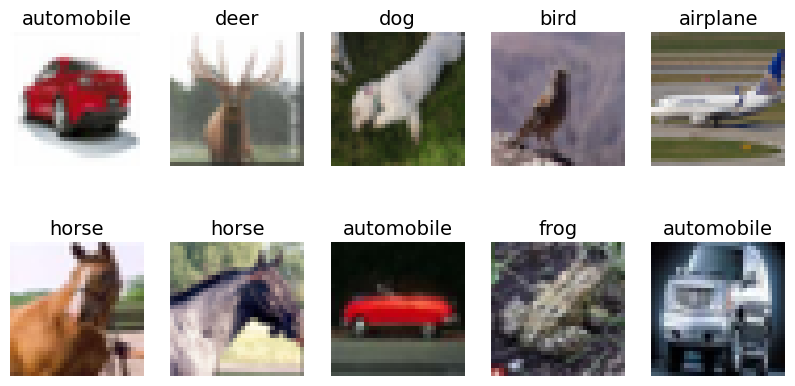

In [11]:
plt.figure(figsize=(10, 5))

for i in range(10):
    k = np.random.choice(len(X_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[k])
    plt.title(class_names[y_train[k][0]])   ## As previously shown
    plt.axis("off")
plt.show()


About to encode y, doing this before the plot makes everything incredibly messy

In [12]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

you dont need to encode the integer values if you use sparse_categorical_crossentropy instead of categorical_crossentropy.

In [13]:
# X_train = np.expand_dims(X_train, axis=-1)
# X_valid = np.expand_dims(X_valid, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

## not necessary as tensors already have the correct number of dimensions for

##  Building an Image Augmentor

In [14]:
idg = ImageDataGenerator(
    # rotation_range=5,        # random rotation up to 15 degrees
    width_shift_range=0.05,    # horizontal shift
    height_shift_range=0.05,   # vertical shift
    horizontal_flip=True,     # randomly flip images
    zoom_range=0.1,           # zoom in/out
    fill_mode="nearest",       # fill missing pixels
    # brightness_range = [0.9, 1.1]
)

idg.fit(X_train)

image_augmentor = idg.flow(
    X_train,
    y_train,
    batch_size=64
)

# Model 1

## Architecture

In [15]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),                            # pooling layer
    tf.keras.layers.Flatten(),                              # bridge to the dense layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

I0000 00:00:1771501189.003027  164855 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11006 MB memory:  -> device: 0, name: AMD Radeon RX 6750 XT, pci bus id: 0000:2d:00.0


In [16]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        81,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,826 (323.54 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [17]:
model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [18]:
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=model_1_optimizer,
    metrics=["accuracy"]
    )

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,                 # metric to monitor             # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [20]:
model_1_history = model_1.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping])

Epoch 1/100


2026-02-19 11:39:50.987933: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1730007c70 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-02-19 11:39:50.987946: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 6750 XT, AMDGPU ISA version: gfx1030
2026-02-19 11:39:51.003640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  28/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0764 - loss: 2.9726

I0000 00:00:1771501192.911263  165071 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2293 - loss: 2.2305

2026-02-19 11:39:58.243156: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2295 - loss: 2.2299

2026-02-19 11:40:02.728601: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3128 - loss: 1.9540 - val_accuracy: 0.4516 - val_loss: 1.6058
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4542 - loss: 1.5606 - val_accuracy: 0.5024 - val_loss: 1.4743
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5017 - loss: 1.4425 - val_accuracy: 0.5218 - val_loss: 1.4040
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5256 - loss: 1.3706 - val_accuracy: 0.5348 - val_loss: 1.3606
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5420 - loss: 1.3221 - val_accuracy: 0.5536 - val_loss: 1.3173
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5573 - loss: 1.2873 - val_accuracy: 0.5598 - val_loss: 1.2878
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5665 - loss: 1.2541 - val_accuracy: 0.5736 - val_loss: 1.2616
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5745 - loss: 1.2317 - val

## Evaluating Model

In [21]:
model_1_accuracy = model_1_history.history["accuracy"]
model_1_accuracy_val = model_1_history.history["val_accuracy"]
model_1_loss = model_1_history.history["loss"]
model_1_loss_val = model_1_history.history["val_loss"]

model_1_epochs = range(1,len(model_1_accuracy)+1)


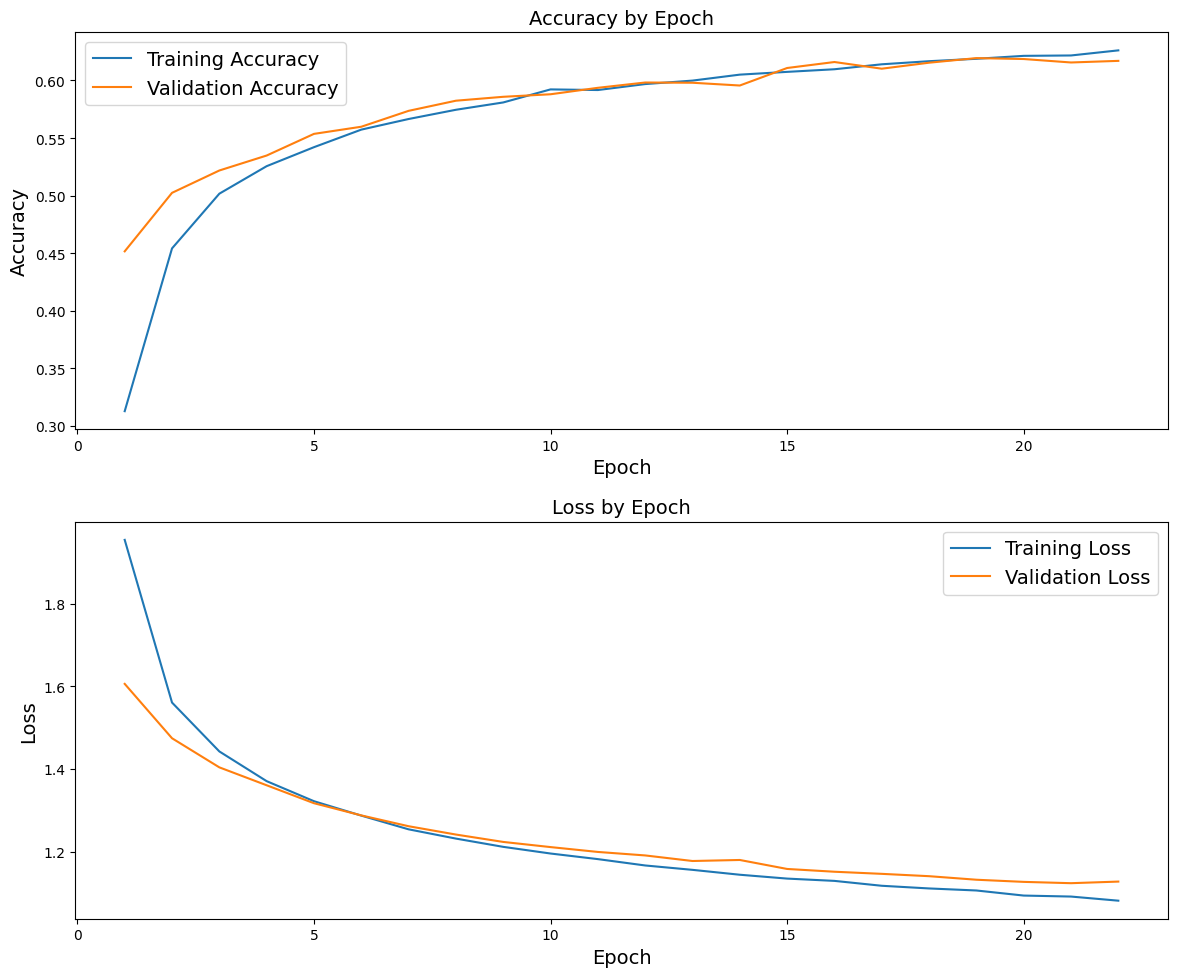

In [22]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_1_epochs, model_1_accuracy, label="Training Accuracy")
plt.plot(model_1_epochs, model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_1_epochs, model_1_loss, label="Training Loss")
plt.plot(model_1_epochs, model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



In [23]:
y_pred_model_1_probs = model_1.predict(X_test)
y_pred_model_1 = y_pred_model_1_probs.argmax(axis=1)
y_test_model_1 = y_test.argmax(axis=1)              ## to make sure y pred and y test are the same shape

acc = accuracy_score(y_test_model_1, y_pred_model_1)
prec = precision_score(y_test_model_1, y_pred_model_1, average='weighted')
rec = recall_score(y_test_model_1, y_pred_model_1, average='weighted')
f1 = f1_score(y_test_model_1, y_pred_model_1, average='weighted')

print(f"model_1 Accuracy: {acc:.4f}")
print(f"model_1 Precision: {prec:.4f}")
print(f"model_1 Recall: {rec:.4f}")
print(f"model_1 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_1, y_pred_model_1, target_names=class_names)
print(report)

279/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2026-02-19 11:42:02.548308: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
model_1 Accuracy: 0.6148
model_1 Precision: 0.6136
model_1 Recall: 0.6148
model_1 F1 Score: 0.6122
              precision    recall  f1-score   support

    airplane       0.63      0.72      0.67      1000
  automobile       0.71      0.74      0.73      1000
        bird       0.47      0.46      0.47      1000
         cat       0.48      0.39      0.43      1000
        deer       0.54      0.52      0.53      1000
         dog       0.52      0.56      0.54      1000
        frog       0.64      0.77      0.70      1000
       horse       0.68      0.67      0.67      1000
        ship       0.75      0.69      0.72      1000
       truck       0.71      0.62      0.67      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



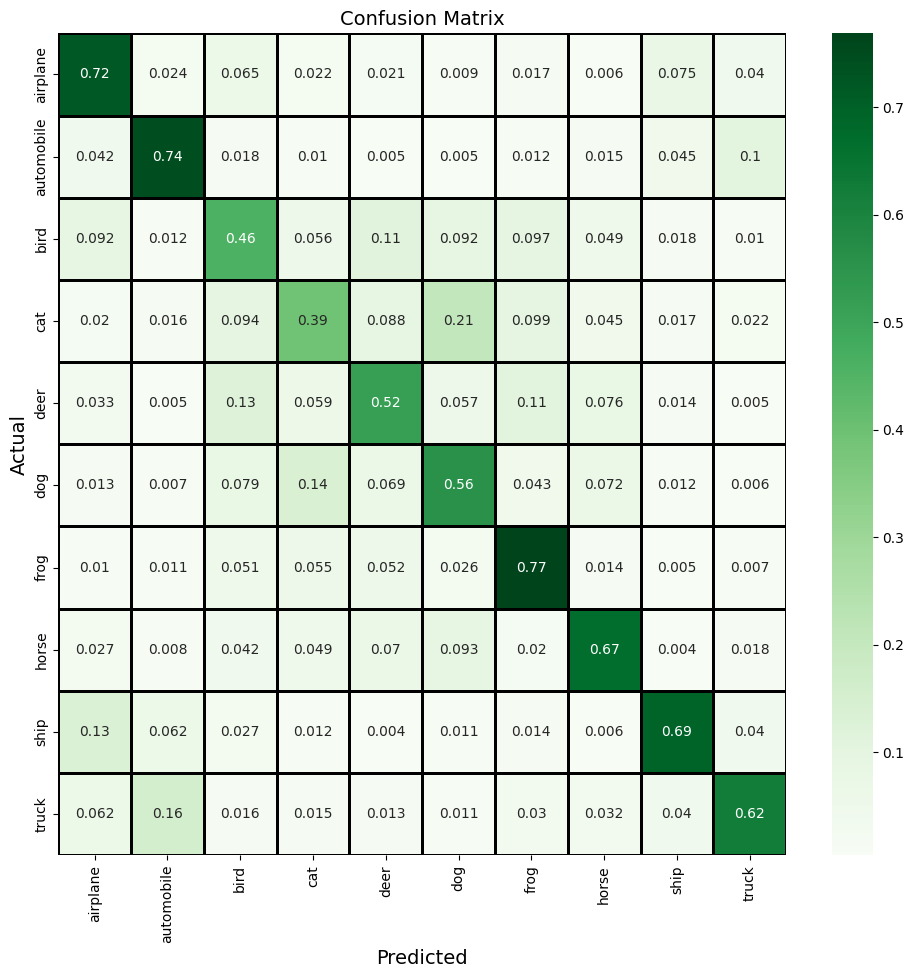

In [24]:
cm_model_1 = confusion_matrix(y_test_model_1, y_pred_model_1,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_model_1,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Model 2

## Architecture

In [25]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                           # pooling layer

    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Conv2D(
        128,
        kernel_size=3,
        padding="valid",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Flatten(),                              # bridge to the dense layer

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [26]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,298 (1.10 MB)

 Trainable params: 288,298 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [27]:
model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [28]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer= model_2_optimizer,
    metrics=["accuracy"]
    )

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',                 # metric to monitor             
    patience=3,                         # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [30]:
model_2_history = model_2.fit(
    image_augmentor,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
317/704 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2296 - loss: 2.0779

2026-02-19 11:42:15.398189: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3001 - loss: 1.8894

2026-02-19 11:42:26.745407: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.3947 - loss: 1.6408 - val_accuracy: 0.5126 - val_loss: 1.3467
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5578 - loss: 1.2299 - val_accuracy: 0.6554 - val_loss: 0.9847
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6323 - loss: 1.0444 - val_accuracy: 0.6932 - val_loss: 0.8941
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6711 - loss: 0.9413 - val_accuracy: 0.7098 - val_loss: 0.8519
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6955 - loss: 0.8737 - val_accuracy: 0.7468 - val_loss: 0.7605
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7141 - loss: 0.8222 - val_accuracy: 0.7340 - val_loss: 0.7882
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7288 - loss: 0.7823 - val_accuracy: 0.7478 - val_loss: 0.7420
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7426 - loss: 0.7453 - val_

## Evaluating Model

In [31]:
model_2_accuracy = model_2_history.history["accuracy"]
model_2_accuracy_val = model_2_history.history["val_accuracy"]
model_2_loss = model_2_history.history["loss"]
model_2_loss_val = model_2_history.history["val_loss"]

model_2_epochs = range(1,len(model_2_accuracy)+1)

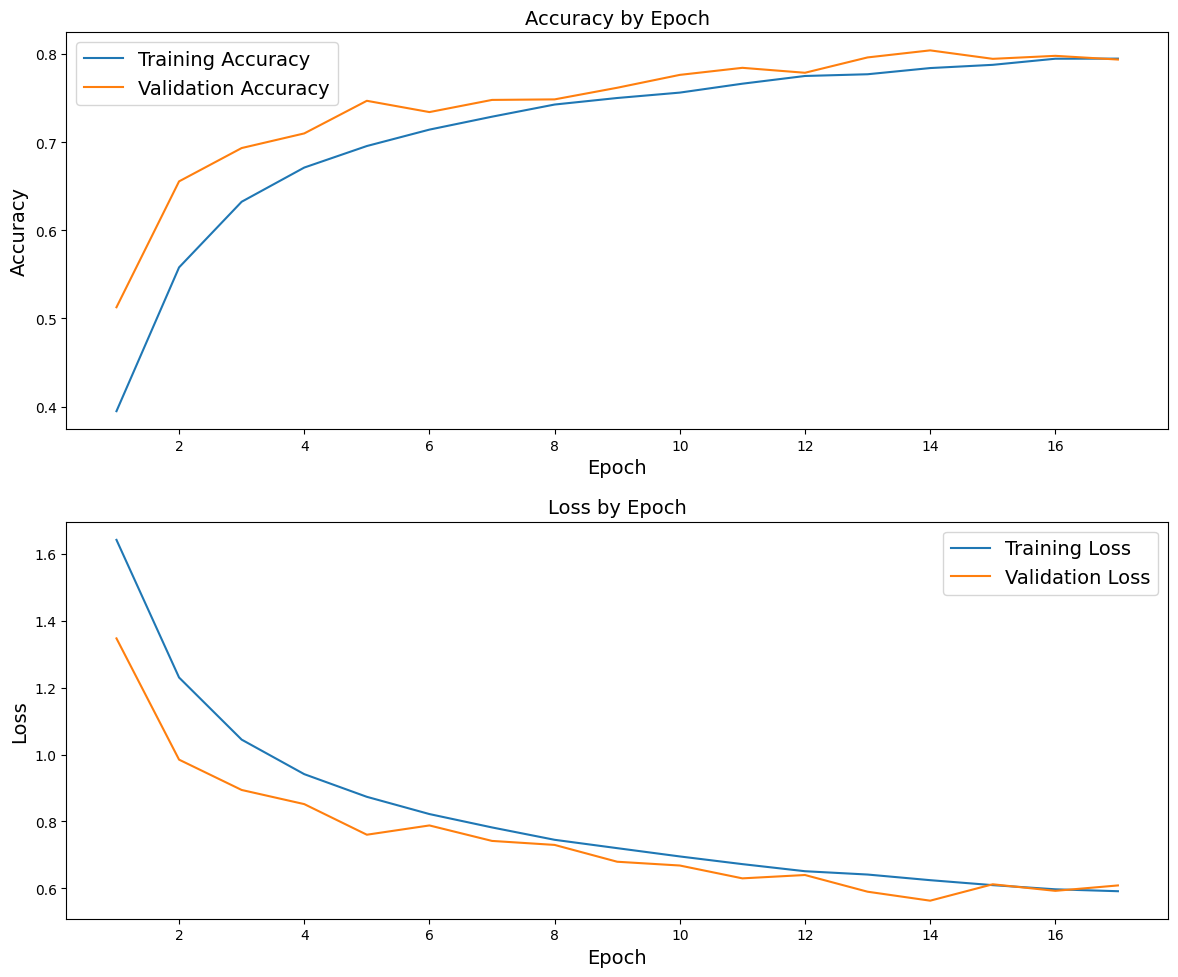

In [32]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_2_epochs, model_2_accuracy, label="Training Accuracy")
plt.plot(model_2_epochs, model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_2_epochs, model_2_loss, label="Training Loss")
plt.plot(model_2_epochs, model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
y_pred_model_2_probs = model_2.predict(X_test)
y_pred_model_2 = y_pred_model_2_probs.argmax(axis=1)
y_test_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_model_2, y_pred_model_2)
prec = precision_score(y_test_model_2, y_pred_model_2, average='weighted')
rec = recall_score(y_test_model_2, y_pred_model_2, average='weighted')
f1 = f1_score(y_test_model_2, y_pred_model_2, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_2, y_pred_model_2, target_names=class_names)
print(f"\n{report}")

292/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2026-02-19 11:45:55.620608: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
model_2 Accuracy: 0.8025
model_2 Precision: 0.8016
model_2 Recall: 0.8025
model_2 F1 Score: 0.8005

              precision    recall  f1-score   support

    airplane       0.82      0.82      0.82      1000
  automobile       0.90      0.91      0.91      1000
        bird       0.79      0.61      0.69      1000
         cat       0.66      0.66      0.66      1000
        deer       0.76      0.79      0.78      1000
         dog       0.73      0.72      0.72      1000
        frog       0.80      0.89      0.84      1000
       horse       0.85      0.83      0.84      1000
        ship       0.87      0.89      0.88      1000
       truck       0.83      0.91      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



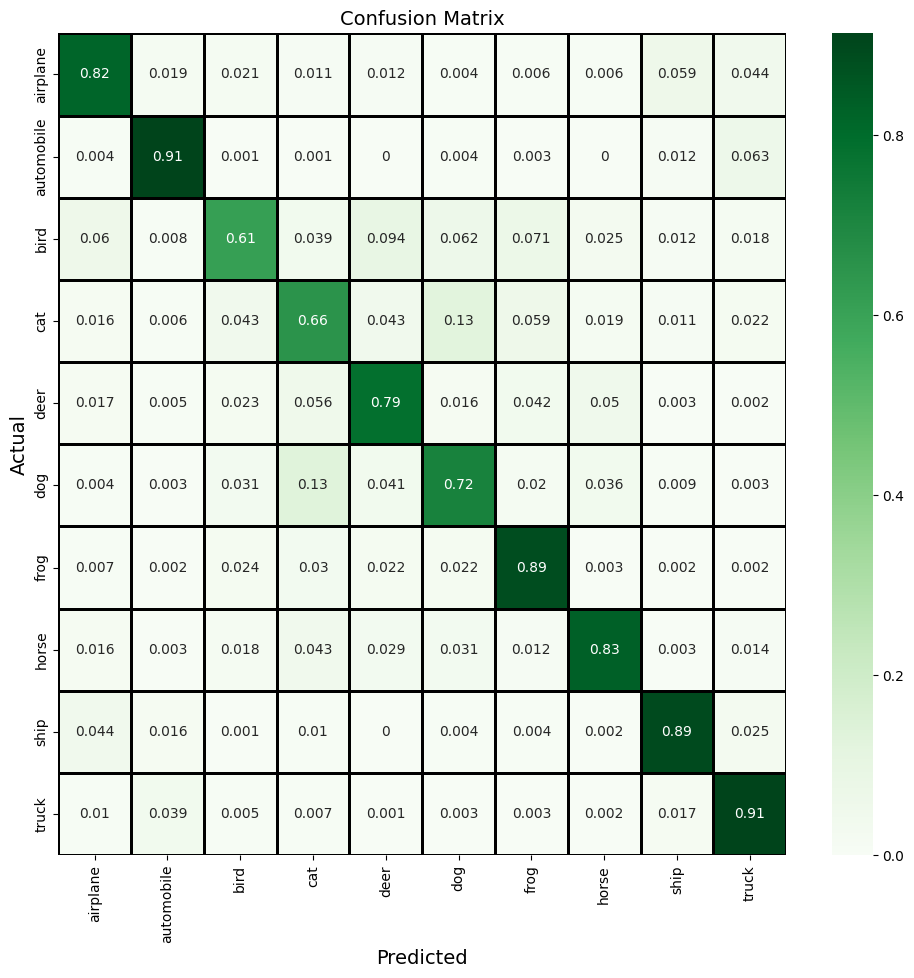

In [34]:
cm_model_2 = confusion_matrix(y_test_model_2, y_pred_model_2,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_model_2,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Scaling for transfer models (64,64,3) --- 

*Mobile net has a stride problem, for images this small we need to reduce its stride but doing so essentiall requires a rewrite.*

updating image augmentor to rescale images to 64,64,3 - 96,96,3 may be better for alogtihms but for local running 64 is more reasonable.

In [35]:
X_train_scaled_64 = tf.image.resize(X_train, (64, 64), antialias=True)
X_valid_scaled_64 = tf.image.resize(X_valid, (64, 64), antialias=True)
X_test_scaled_64  = tf.image.resize(X_test, (64, 64), antialias=True)


2026-02-19 11:45:58.298009: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2211840000 exceeds 10% of free system memory.
2026-02-19 11:45:58.298059: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1105920000 exceeds 10% of free system memory.


In [36]:
image_augmentor_scaled_64 = idg.flow(
    X_train_scaled_64,
    y_train,
    batch_size=64
)

# Transfer Learning Mobile Net v2  - Attempt 1  - All layers Frozen

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [42]:
base_model_1 = MobileNetV2(
    input_shape=(64, 64, 3),    # 32,32,3 is the lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",            # has a meltdown if this is set to anything other than "None"
    weights="imagenet"
    )
base_model_1.trainable = False  # Freeze base so mobilenet v2 isn't being trained

/tmp/ipykernel_164855/1613259723.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_1 = MobileNetV2(


In [43]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [44]:
transfer_model_1 = models.Sequential([
    base_model_1,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [45]:
transfer_model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_1.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_1_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [46]:
transfer_model_1_history = transfer_model_1.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5109 - loss: 1.4070 - val_accuracy: 0.6214 - val_loss: 1.0873
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.5936 - loss: 1.1729 - val_accuracy: 0.6464 - val_loss: 1.0229
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6082 - loss: 1.1238 - val_accuracy: 0.6472 - val_loss: 1.0039
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6218 - loss: 1.0920 - val_accuracy: 0.6586 - val_loss: 0.9927
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6264 - loss: 1.0694 - val_accuracy: 0.6580 - val_loss: 0.9816
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6308 - loss: 1.0582 - val_accuracy: 0.6582 - val_loss: 0.9779
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6335 - loss: 1.0407 - val_accuracy: 0.6686 - val_loss: 0.9681
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6398 - loss: 1

## Evaluating Model

In [47]:
transfer_model_1_accuracy = transfer_model_1_history.history["accuracy"]
transfer_model_1_accuracy_val = transfer_model_1_history.history["val_accuracy"]
transfer_model_1_loss = transfer_model_1_history.history["loss"]
transfer_model_1_loss_val = transfer_model_1_history.history["val_loss"]

transfer_model_1_history_epochs = range(1,len(transfer_model_1_accuracy)+1)

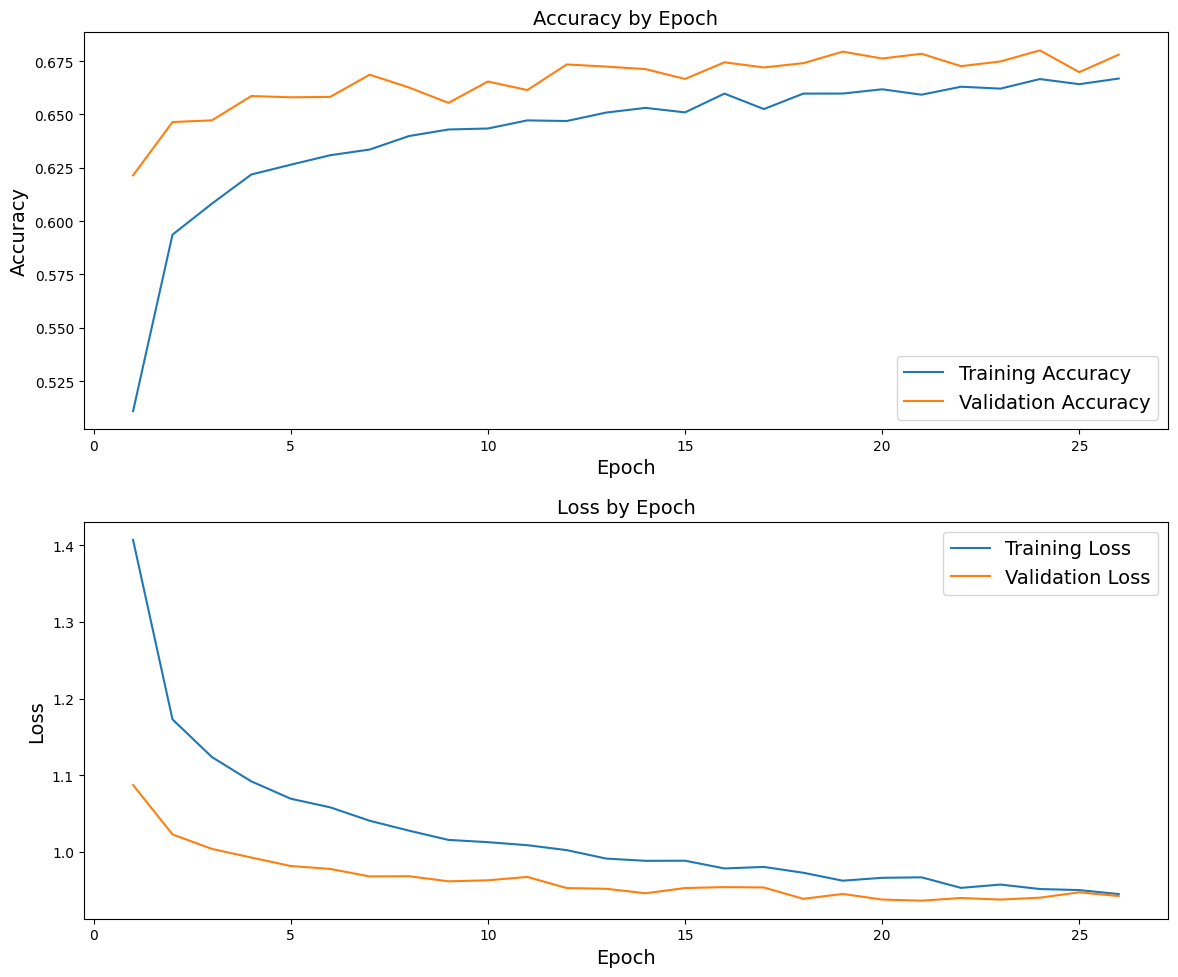

In [48]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy, label="Training Accuracy")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss, label="Training Loss")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
y_pred_transfer_model_1_probs = transfer_model_1.predict(X_test_scaled_64)
y_pred_transfer_model_1 = y_pred_transfer_model_1_probs.argmax(axis=1)
y_test_transfer_model_1 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_1, y_pred_transfer_model_1)
prec = precision_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted')
rec = recall_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted')
f1 = f1_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_1, y_pred_transfer_model_1, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
model_2 Accuracy: 0.6842
model_2 Precision: 0.6825
model_2 Recall: 0.6842
model_2 F1 Score: 0.6826

              precision    recall  f1-score   support

    airplane       0.70      0.69      0.70      1000
  automobile       0.78      0.79      0.79      1000
        bird       0.62      0.58      0.60      1000
         cat       0.59      0.51      0.55      1000
        deer       0.59      0.61      0.60      1000
         dog       0.64      0.63      0.64      1000
        frog       0.66      0.75      0.70      1000
       horse       0.74      0.70      0.72      1000
        ship       0.76      0.78      0.77      1000
       truck       0.75      0.81      0.78      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



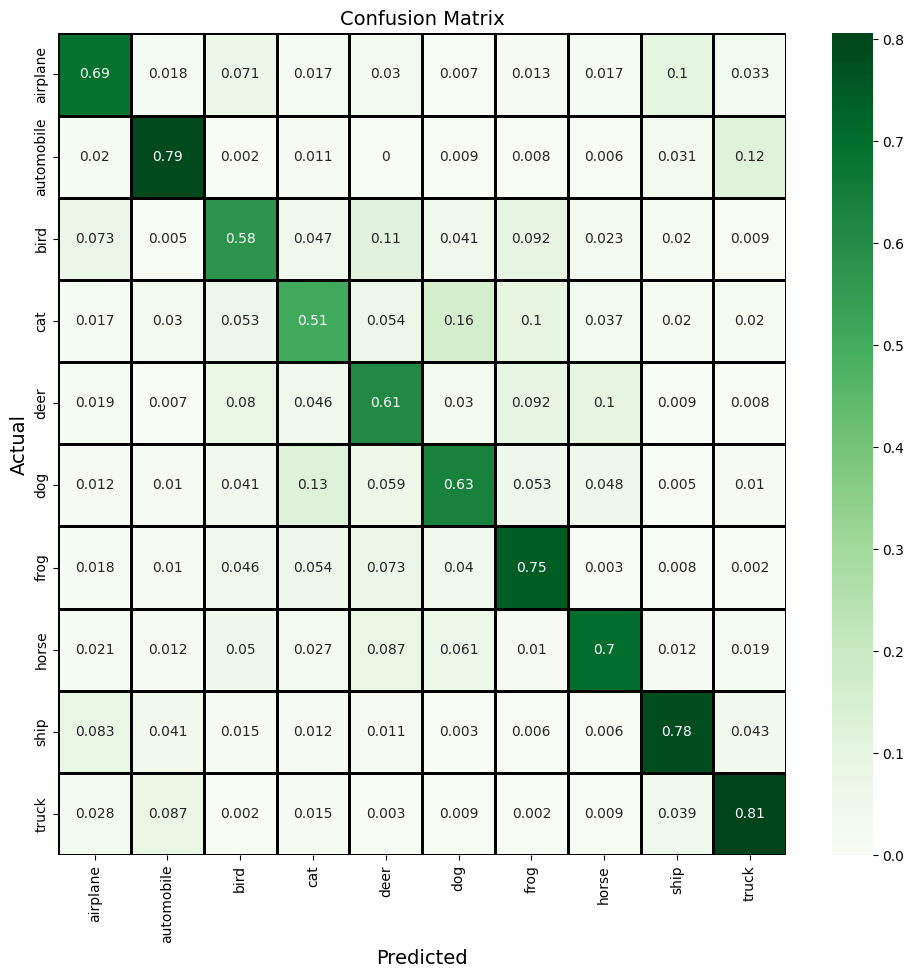

In [50]:
cm_transfer_model_1 = confusion_matrix(y_test_transfer_model_1, y_pred_transfer_model_1,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_1,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning Mobile Net v2  - Attempt 2  - Unfreeze 40 of 155 layers

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [51]:
base_model_2 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

/tmp/ipykernel_164855/1932568423.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_2 = MobileNetV2(


In [52]:
len(base_model_2.layers)

154

In [53]:
for layer in base_model_2.layers[-40:]:
    layer.trainable = True


In [54]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [55]:
transfer_model_2 = models.Sequential([
    base_model_2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [56]:
transfer_model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_2.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_2_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [57]:
transfer_model_2_history = transfer_model_2.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - accuracy: 0.6748 - loss: 1.0226 - val_accuracy: 0.3436 - val_loss: 2.9648
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7570 - loss: 0.7602 - val_accuracy: 0.1190 - val_loss: 4.2598
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.7489 - loss: 0.7813 - val_accuracy: 0.4256 - val_loss: 2.6040
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7952 - loss: 0.6416 - val_accuracy: 0.5962 - val_loss: 1.9482
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8028 - loss: 0.6039 - val_accuracy: 0.6256 - val_loss: 1.4102
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7700 - loss: 0.6990 - val_accuracy: 0.2918 - val_loss: 5.0514
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7922 - loss: 0.6259 - val_accuracy: 0.4610 - val_loss: 2.5197
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7797 - loss: 0

## Evaluating Model

In [58]:
transfer_model_2_accuracy = transfer_model_2_history.history["accuracy"]
transfer_model_2_accuracy_val = transfer_model_2_history.history["val_accuracy"]
transfer_model_2_loss = transfer_model_2_history.history["loss"]
transfer_model_2_loss_val = transfer_model_2_history.history["val_loss"]

transfer_model_2_history_epochs = range(1,len(transfer_model_2_accuracy)+1)

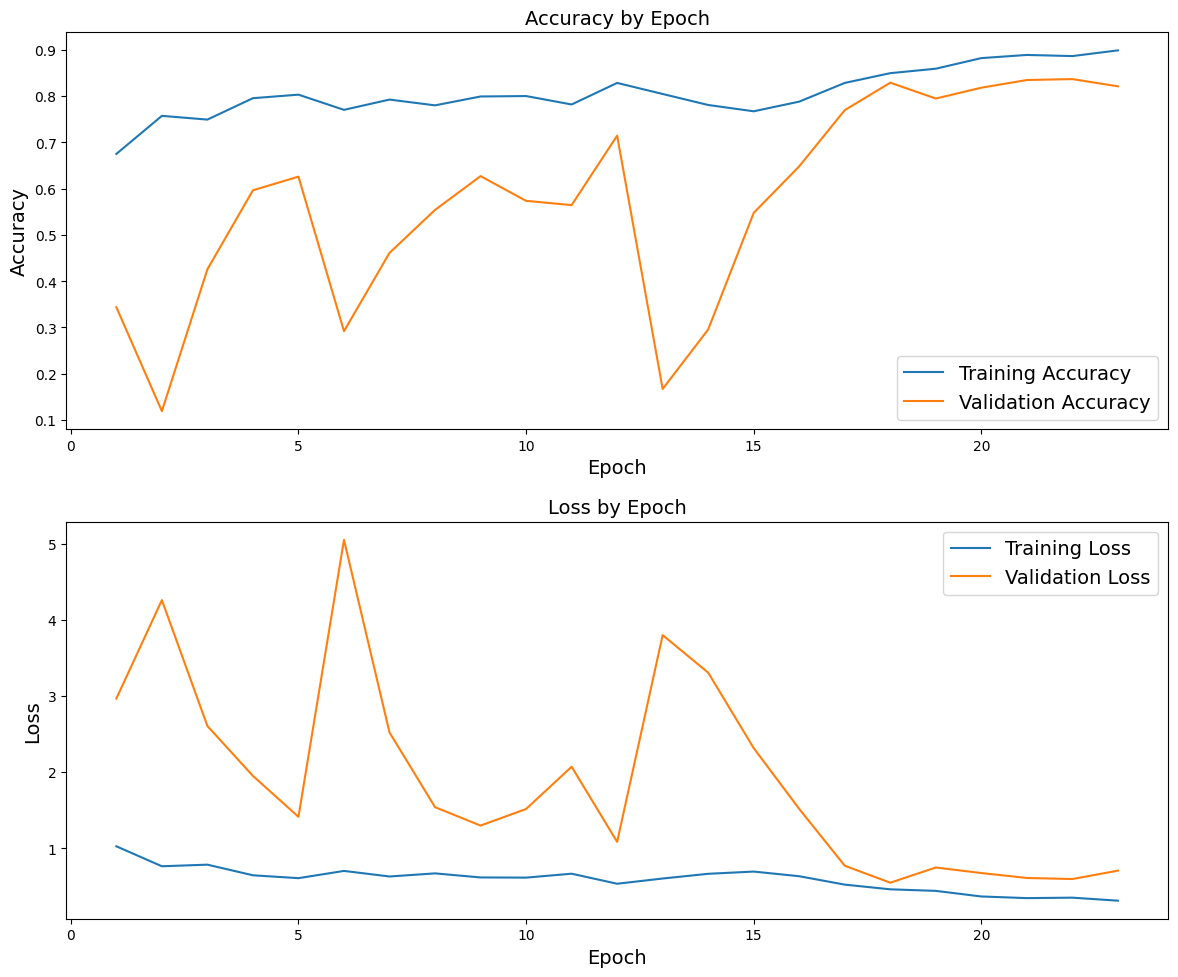

In [59]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy, label="Training Accuracy")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss, label="Training Loss")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
y_pred_transfer_model_2_probs = transfer_model_2.predict(X_test_scaled_64)
y_pred_transfer_model_2 = y_pred_transfer_model_2_probs.argmax(axis=1)
y_test_transfer_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_2, y_pred_transfer_model_2)
prec = precision_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted')
rec = recall_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted')
f1 = f1_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_2, y_pred_transfer_model_2, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
model_2 Accuracy: 0.8368
model_2 Precision: 0.8424
model_2 Recall: 0.8368
model_2 F1 Score: 0.8312

              precision    recall  f1-score   support

    airplane       0.78      0.89      0.83      1000
  automobile       0.82      0.97      0.89      1000
        bird       0.77      0.83      0.80      1000
         cat       0.90      0.46      0.61      1000
        deer       0.85      0.85      0.85      1000
         dog       0.76      0.79      0.77      1000
        frog       0.82      0.91      0.87      1000
       horse       0.89      0.89      0.89      1000
        ship       0.93      0.89      0.91      1000
       truck       0.91      0.89      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000



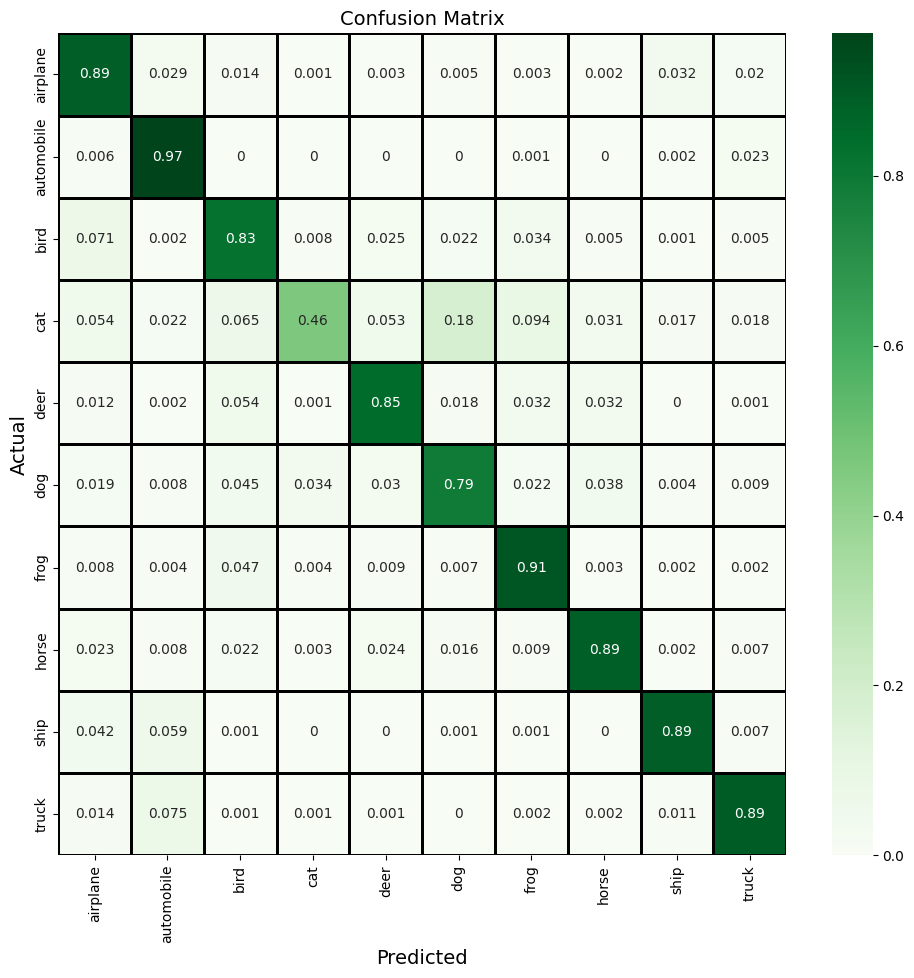

In [61]:
cm_transfer_model_2 = confusion_matrix(y_test_transfer_model_2, y_pred_transfer_model_2,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_2,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning Mobile Net v2  - Attempt 3  - Unfreeze Fewer Layers - 20

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [62]:
base_model_3 = MobileNetV2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet",
    )

/tmp/ipykernel_164855/415551669.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_3 = MobileNetV2(


In [63]:
for layer in base_model_3.layers[-20:]:
    layer.trainable = True

In [64]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [65]:
transfer_model_3 = models.Sequential([
    base_model_3,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [66]:
transfer_model_3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_3.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_3_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    patience=5,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [67]:
transfer_model_3_history = transfer_model_3.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.6968 - loss: 0.9578 - val_accuracy: 0.4444 - val_loss: 4.8246
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7895 - loss: 0.6758 - val_accuracy: 0.1252 - val_loss: 2.5141
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7627 - loss: 0.7165 - val_accuracy: 0.2586 - val_loss: 2.5886
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7779 - loss: 0.6801 - val_accuracy: 0.5022 - val_loss: 2.4742
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7694 - loss: 0.6965 - val_accuracy: 0.6020 - val_loss: 1.6041
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8189 - loss: 0.5605 - val_accuracy: 0.4174 - val_loss: 3.5557
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7850 - loss: 0.6612 - val_accuracy: 0.4072 - val_loss: 4.0269
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7828 - loss: 0

## Evaluating Model

In [68]:
transfer_model_3_accuracy = transfer_model_3_history.history["accuracy"]
transfer_model_3_accuracy_val = transfer_model_3_history.history["val_accuracy"]
transfer_model_3_loss = transfer_model_3_history.history["loss"]
transfer_model_3_loss_val = transfer_model_3_history.history["val_loss"]

transfer_model_3_history_epochs = range(1,len(transfer_model_3_accuracy)+1)

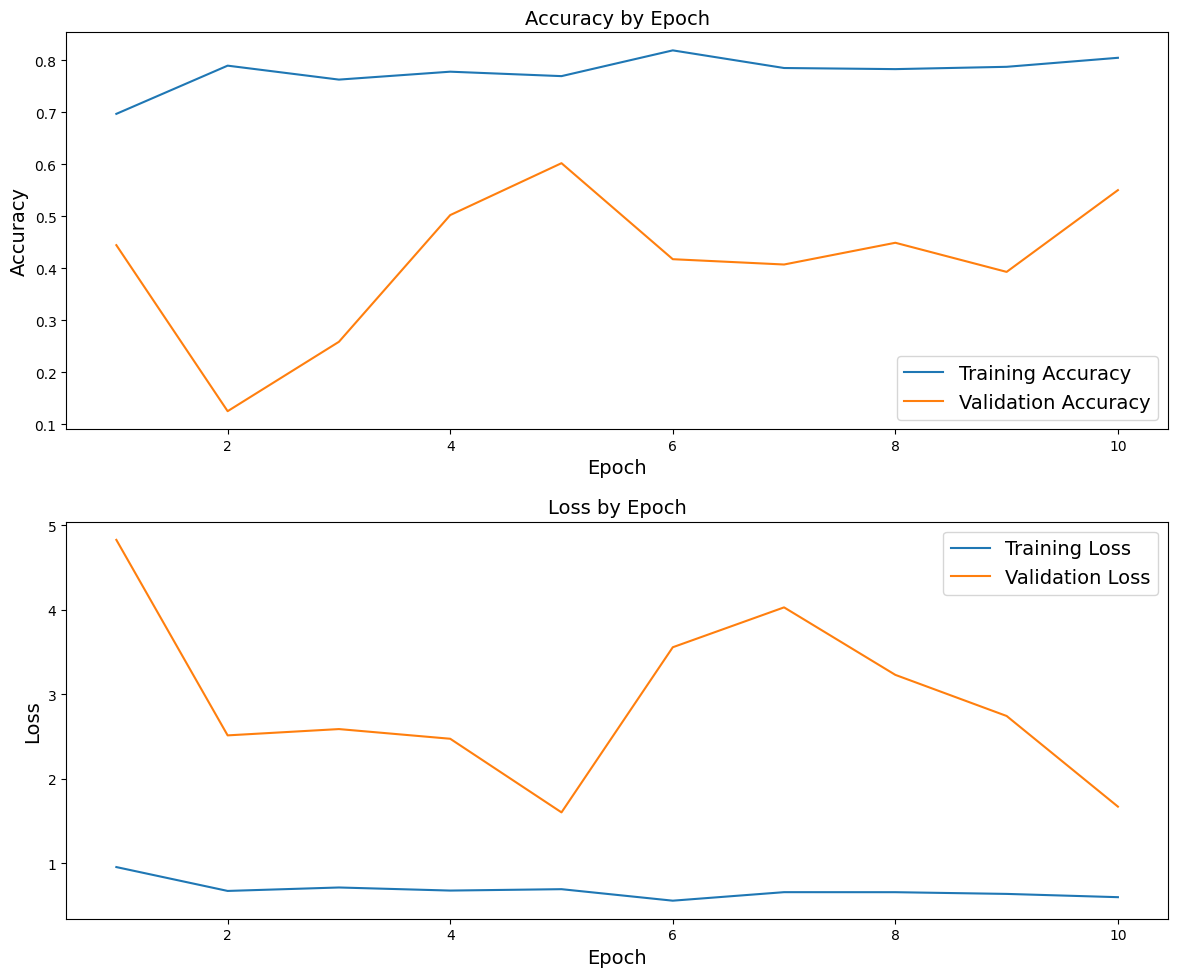

In [69]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy, label="Training Accuracy")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss, label="Training Loss")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [70]:
y_pred_transfer_model_3_probs = transfer_model_3.predict(X_test_scaled_64)
y_pred_transfer_model_3 = y_pred_transfer_model_3_probs.argmax(axis=1)
y_test_transfer_model_3 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_3, y_pred_transfer_model_3)
prec = precision_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted')
rec = recall_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted')
f1 = f1_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_3, y_pred_transfer_model_3, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
model_2 Accuracy: 0.6202
model_2 Precision: 0.6950
model_2 Recall: 0.6202
model_2 F1 Score: 0.6223

              precision    recall  f1-score   support

    airplane       0.56      0.59      0.58      1000
  automobile       0.39      0.93      0.55      1000
        bird       0.51      0.66      0.57      1000
         cat       0.76      0.39      0.51      1000
        deer       0.78      0.57      0.66      1000
         dog       0.68      0.68      0.68      1000
        frog       0.91      0.53      0.67      1000
       horse       0.67      0.84      0.75      1000
        ship       0.78      0.38      0.51      1000
       truck       0.92      0.62      0.74      1000

    accuracy                           0.62     10000
   macro avg       0.69      0.62      0.62     10000
weighted avg       0.69      0.62      0.62     10000



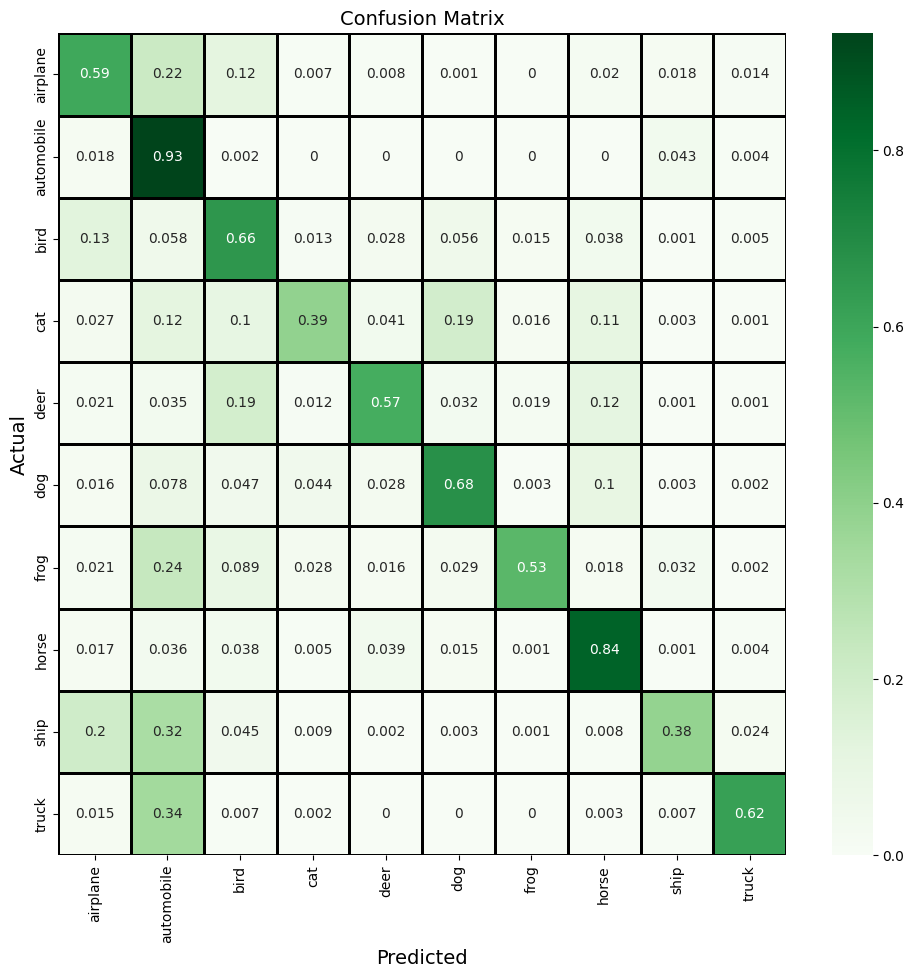

In [71]:
cm_transfer_model_3 = confusion_matrix(y_test_transfer_model_3, y_pred_transfer_model_3,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_3,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning ResNet50V2  - Attempt 1 - All layers Frozen

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [72]:
base_model_4 = ResNet50V2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )
base_model_4.trainable = False  # Don't freeze base so EfficientNetB0 can be trained as we have no weights just the structure

In [73]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [74]:
transfer_model_4 = models.Sequential([
    base_model_4,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, ResNet50V2 won't put out a raw image
    output
])

In [75]:
transfer_model_4_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_4.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_4_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.01,             # metric to monitor
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [76]:
transfer_model_4_history = transfer_model_4.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4998 - loss: 1.4591 - val_accuracy: 0.6146 - val_loss: 1.1165
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5770 - loss: 1.2257 - val_accuracy: 0.6350 - val_loss: 1.0480
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5968 - loss: 1.1609 - val_accuracy: 0.6432 - val_loss: 1.0160
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6042 - loss: 1.1292 - val_accuracy: 0.6474 - val_loss: 1.0016
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6150 - loss: 1.1045 - val_accuracy: 0.6530 - val_loss: 0.9853
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6196 - loss: 1.0852 - val_accuracy: 0.6542 - val_loss: 0.9883
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.6283 - loss: 1.0706 - val_accuracy: 0.6622 - val_loss: 0.9660
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6311 - loss: 1

## Evaluating Model

In [77]:
transfer_model_4_accuracy = transfer_model_4_history.history["accuracy"]
transfer_model_4_accuracy_val = transfer_model_4_history.history["val_accuracy"]
transfer_model_4_loss = transfer_model_4_history.history["loss"]
transfer_model_4_loss_val = transfer_model_4_history.history["val_loss"]

transfer_model_4_history_epochs = range(1,len(transfer_model_4_accuracy)+1)

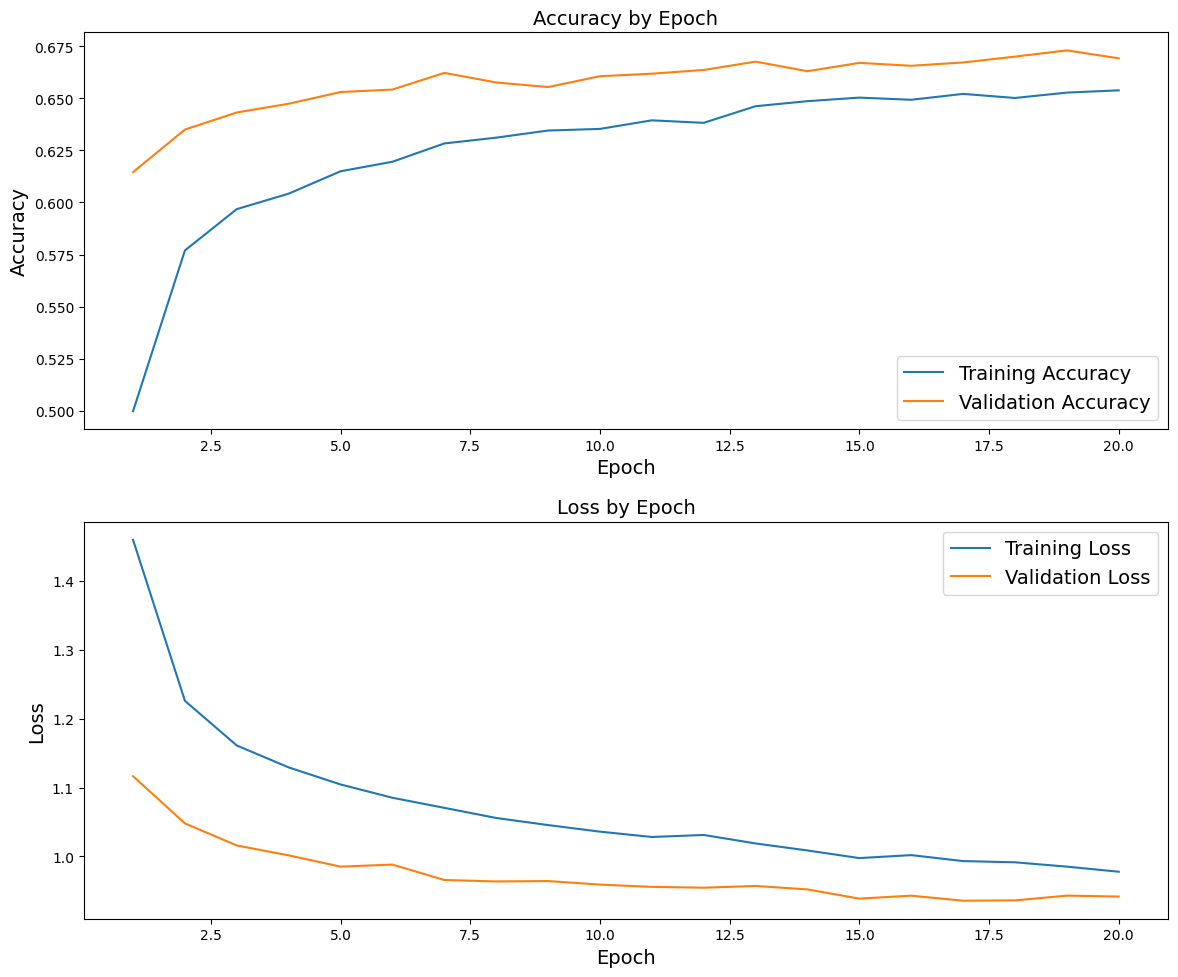

In [78]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy, label="Training Accuracy")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss, label="Training Loss")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
y_pred_transfer_model_4_probs = transfer_model_4.predict(X_test_scaled_64)
y_pred_transfer_model_4 = y_pred_transfer_model_4_probs.argmax(axis=1)
y_test_transfer_model_4 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_4, y_pred_transfer_model_4)
prec = precision_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted')
rec = recall_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted')
f1 = f1_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_4, y_pred_transfer_model_4, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
model_2 Accuracy: 0.6741
model_2 Precision: 0.6731
model_2 Recall: 0.6741
model_2 F1 Score: 0.6722

              precision    recall  f1-score   support

    airplane       0.71      0.72      0.72      1000
  automobile       0.72      0.81      0.76      1000
        bird       0.66      0.57      0.61      1000
         cat       0.54      0.50      0.52      1000
        deer       0.61      0.58      0.59      1000
         dog       0.65      0.63      0.64      1000
        frog       0.64      0.77      0.70      1000
       horse       0.68      0.69      0.69      1000
        ship       0.77      0.73      0.75      1000
       truck       0.74      0.75      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



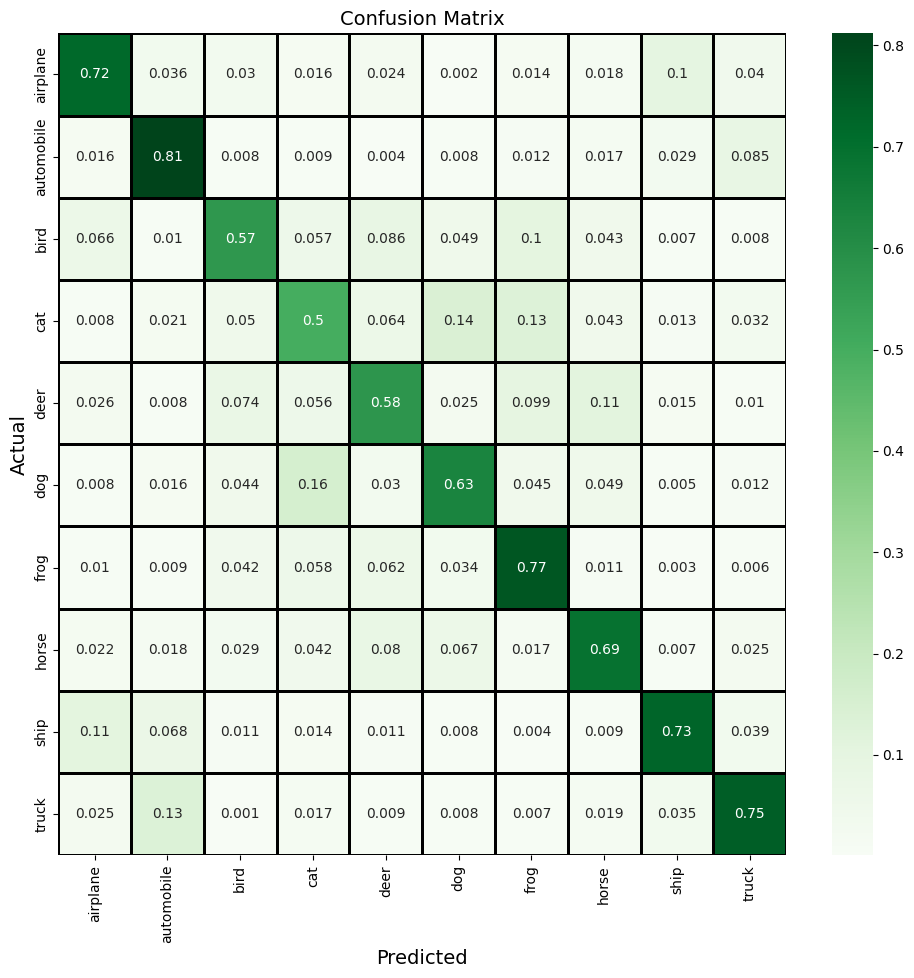

In [80]:
cm_transfer_model_4 = confusion_matrix(y_test_transfer_model_4, y_pred_transfer_model_4,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_4,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning ResNet50V2  - Attempt 2 - Unfreeze 49 of 190 Layers

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [81]:
base_model_5 = ResNet50V2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )


In [82]:
len(base_model_5.layers)

190

In [83]:
for layer in base_model_5.layers[-49:]:             #same ratio of layer as we took from mobilenetv2
    layer.trainable = True


In [84]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [85]:
transfer_model_5 = models.Sequential([
    base_model_5,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [86]:
transfer_model_5_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_5.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_5_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta = 0.01,  
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [87]:
transfer_model_5_history = transfer_model_5.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 96s 102ms/step - accuracy: 0.6312 - loss: 1.1289 - val_accuracy: 0.5874 - val_loss: 1.3643
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.7538 - loss: 0.7664 - val_accuracy: 0.6766 - val_loss: 1.0335
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.7907 - loss: 0.6578 - val_accuracy: 0.6104 - val_loss: 1.4490
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.8075 - loss: 0.5859 - val_accuracy: 0.7356 - val_loss: 0.8574
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.8268 - loss: 0.5308 - val_accuracy: 0.8110 - val_loss: 0.5640
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.8394 - loss: 0.4949 - val_accuracy: 0.7438 - val_loss: 0.8133
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.8500 - loss: 0.4600 - val_accuracy: 0.6634 - val_loss: 1.3161
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - accuracy: 0.8556 - loss: 

## Evaluating Model

In [88]:
transfer_model_5_accuracy = transfer_model_5_history.history["accuracy"]
transfer_model_5_accuracy_val = transfer_model_5_history.history["val_accuracy"]
transfer_model_5_loss = transfer_model_5_history.history["loss"]
transfer_model_5_loss_val = transfer_model_5_history.history["val_loss"]

transfer_model_5_history_epochs = range(1,len(transfer_model_5_accuracy)+1)

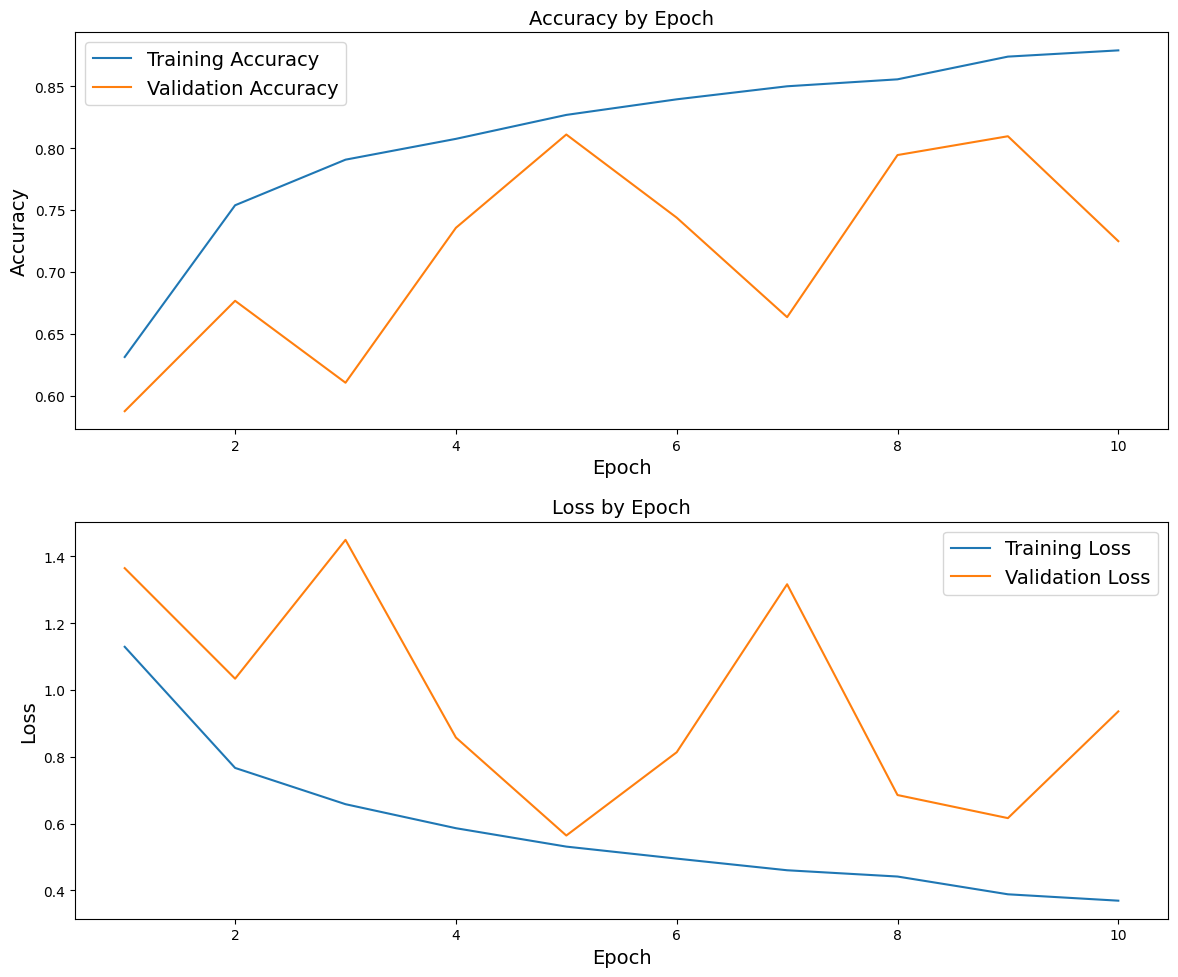

In [89]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_5_history_epochs, transfer_model_5_accuracy, label="Training Accuracy")
plt.plot(transfer_model_5_history_epochs, transfer_model_5_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_5_history_epochs, transfer_model_5_loss, label="Training Loss")
plt.plot(transfer_model_5_history_epochs, transfer_model_5_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [90]:
y_pred_transfer_model_5_probs = transfer_model_5.predict(X_test_scaled_64)
y_pred_transfer_model_5 = y_pred_transfer_model_5_probs.argmax(axis=1)
y_test_transfer_model_5 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_5, y_pred_transfer_model_5)
prec = precision_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted')
rec = recall_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted')
f1 = f1_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_5, y_pred_transfer_model_5, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
model_2 Accuracy: 0.8087
model_2 Precision: 0.8107
model_2 Recall: 0.8087
model_2 F1 Score: 0.8074

              precision    recall  f1-score   support

    airplane       0.73      0.86      0.79      1000
  automobile       0.87      0.91      0.89      1000
        bird       0.78      0.76      0.77      1000
         cat       0.71      0.61      0.66      1000
        deer       0.86      0.69      0.76      1000
         dog       0.70      0.78      0.74      1000
        frog       0.86      0.89      0.87      1000
       horse       0.87      0.84      0.85      1000
        ship       0.87      0.85      0.86      1000
       truck       0.86      0.89      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



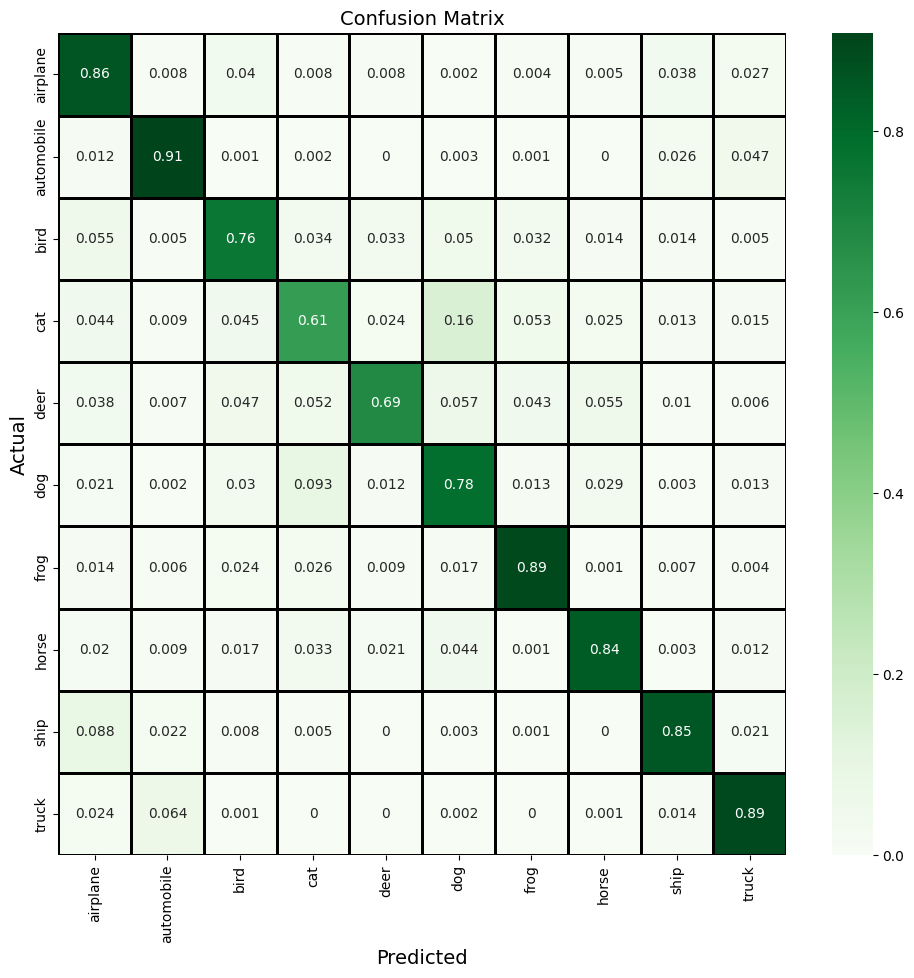

In [91]:
cm_transfer_model_5 = confusion_matrix(y_test_transfer_model_5, y_pred_transfer_model_5,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_5,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Scaling for transfer models (96,96,3) ---

*Mobile net has a stride problem, for images this small we need to reduce its stride but doing so essentiall requires a rewrite.*

updating image augmentor to rescale images to 64,64,3 - 96,96,3 may be better for alogtihms but for local running 64 is more reasonable.

In [92]:
X_train_scaled_96 = tf.image.resize(X_train, (96, 96), antialias=True)
X_valid_scaled_96 = tf.image.resize(X_valid, (96, 96), antialias=True)
X_test_scaled_96  = tf.image.resize(X_test, (96, 96), antialias=True)


2026-02-19 12:43:44.985283: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 4976640000 exceeds 10% of free system memory.
2026-02-19 12:43:44.985326: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1658880000 exceeds 10% of free system memory.
2026-02-19 12:43:49.050051: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1105920000 exceeds 10% of free system memory.


In [93]:
image_augmentor_scaled_96 = idg.flow(
    X_train_scaled_96,
    y_train,
    batch_size=64
)

# Transfer Learning Mobile Net v2  - Attempt 4  - Unfreeze 40 - 96 96 3 version

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the images first, before our model.

In [94]:
base_model_6 = MobileNetV2(
    input_shape=(96, 96, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

In [95]:
len(base_model_6.layers)

154

In [96]:
for layer in base_model_6.layers[-40:]:
    layer.trainable = True


In [97]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [98]:
transfer_model_6 = models.Sequential([
    base_model_6,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [99]:
transfer_model_6_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_6.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_6_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [100]:
transfer_model_6_history = transfer_model_6.fit(
    image_augmentor_scaled_96,
    epochs=100,
    validation_data=(X_valid_scaled_96, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 104s 115ms/step - accuracy: 0.7866 - loss: 0.7036 - val_accuracy: 0.4416 - val_loss: 3.1942
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8550 - loss: 0.4692 - val_accuracy: 0.4662 - val_loss: 2.7229
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8764 - loss: 0.3988 - val_accuracy: 0.7022 - val_loss: 1.3018
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8890 - loss: 0.3540 - val_accuracy: 0.5966 - val_loss: 2.2750
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8973 - loss: 0.3292 - val_accuracy: 0.6846 - val_loss: 1.8301
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9008 - loss: 0.3147 - val_accuracy: 0.6902 - val_loss: 1.5845
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.9124 - loss: 0.2798 - val_accuracy: 0.7624 - val_loss: 1.1438
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.9152 - loss:

## Evaluating Model

In [101]:
transfer_model_6_accuracy = transfer_model_6_history.history["accuracy"]
transfer_model_6_accuracy_val = transfer_model_6_history.history["val_accuracy"]
transfer_model_6_loss = transfer_model_6_history.history["loss"]
transfer_model_6_loss_val = transfer_model_6_history.history["val_loss"]

transfer_model_6_history_epochs = range(1,len(transfer_model_6_accuracy)+1)

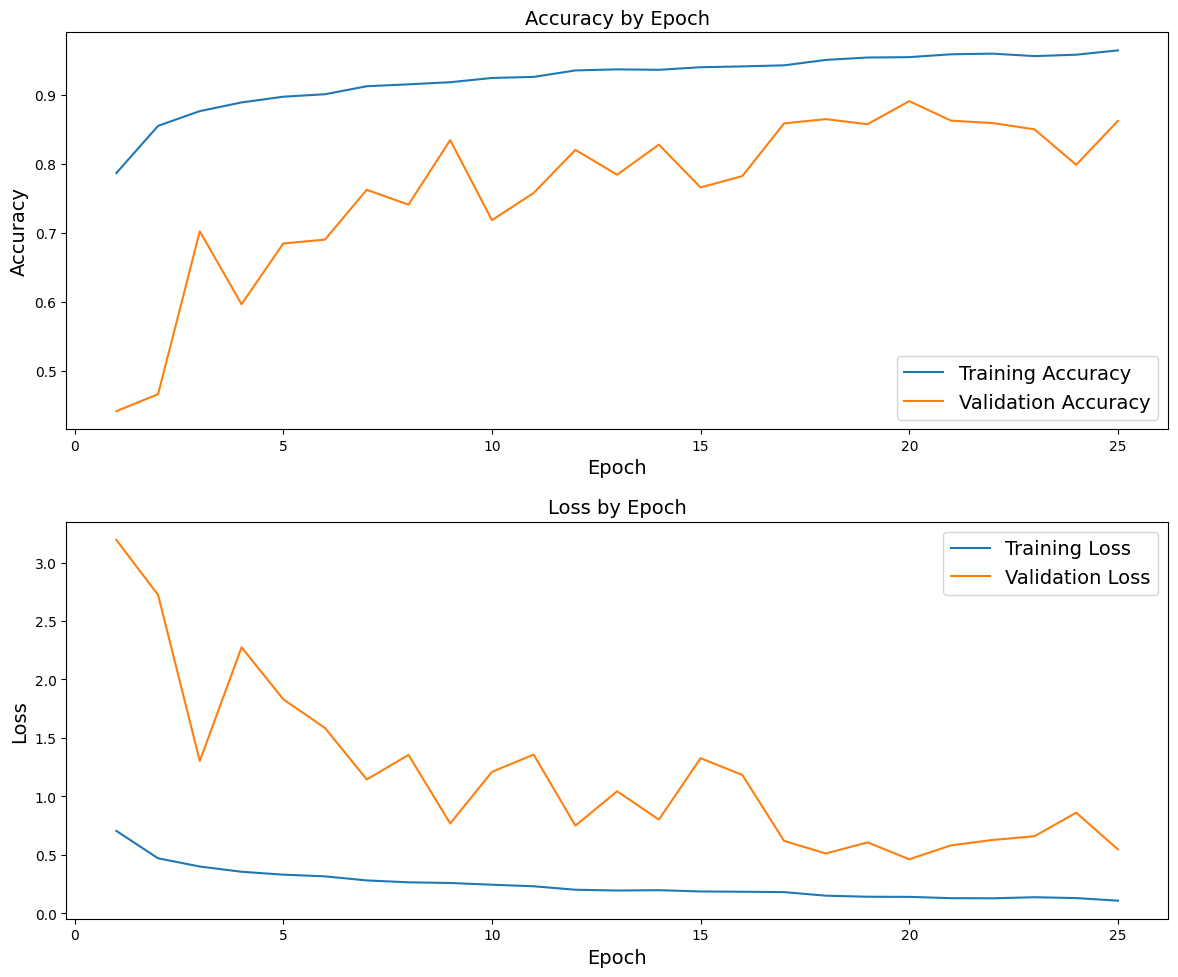

In [102]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_6_history_epochs, transfer_model_6_accuracy, label="Training Accuracy")
plt.plot(transfer_model_6_history_epochs, transfer_model_6_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_6_history_epochs, transfer_model_6_loss, label="Training Loss")
plt.plot(transfer_model_6_history_epochs, transfer_model_6_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [103]:
y_pred_transfer_model_6_probs = transfer_model_6.predict(X_test_scaled_96)
y_pred_transfer_model_6 = y_pred_transfer_model_6_probs.argmax(axis=1)
y_test_transfer_model_6 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_6, y_pred_transfer_model_6)
prec = precision_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted')
rec = recall_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted')
f1 = f1_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted')

print(f"model_6 Accuracy: {acc:.4f}")
print(f"model_6 Precision: {prec:.4f}")
print(f"model_6 Recall: {rec:.4f}")
print(f"model_6 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_6, y_pred_transfer_model_6, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
model_6 Accuracy: 0.8876
model_6 Precision: 0.8908
model_6 Recall: 0.8876
model_6 F1 Score: 0.8873

              precision    recall  f1-score   support

    airplane       0.93      0.84      0.88      1000
  automobile       0.88      0.96      0.92      1000
        bird       0.93      0.81      0.86      1000
         cat       0.78      0.85      0.81      1000
        deer       0.95      0.82      0.88      1000
         dog       0.84      0.83      0.84      1000
        frog       0.93      0.92      0.93      1000
       horse       0.88      0.93      0.90      1000
        ship       0.86      0.96      0.91      1000
       truck       0.92      0.95      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



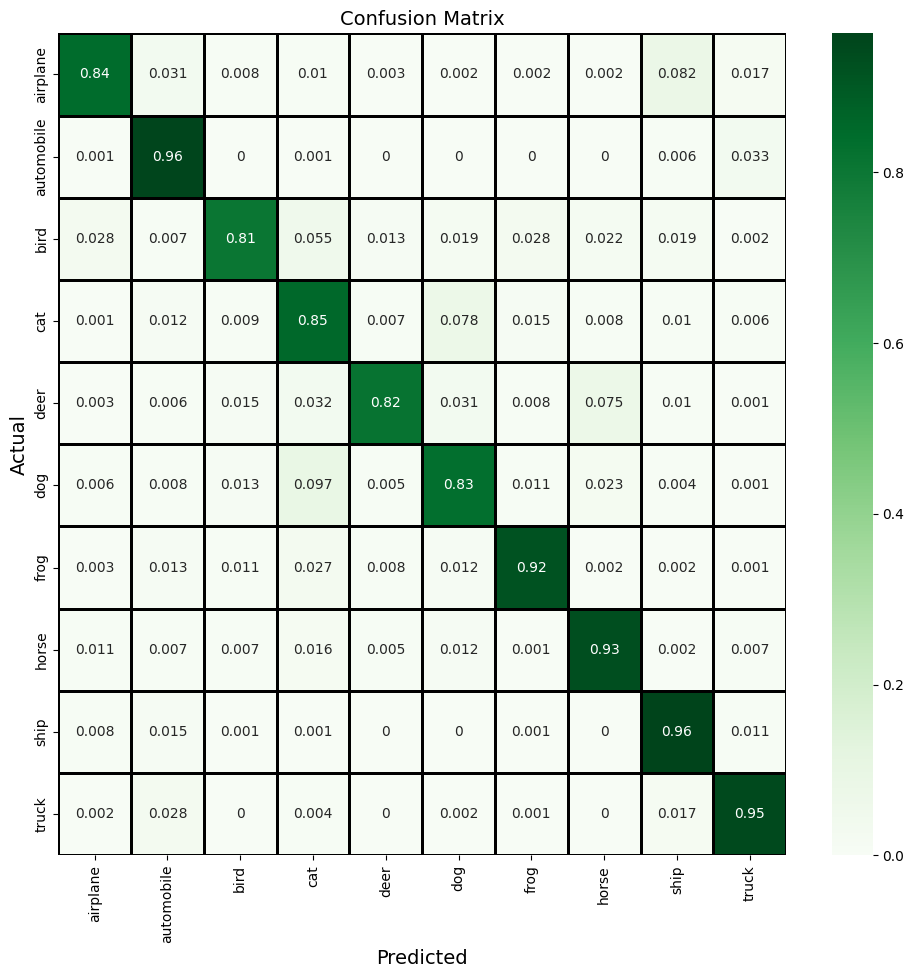

In [104]:
cm_transfer_model_6 = confusion_matrix(y_test_transfer_model_6, y_pred_transfer_model_6,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_6,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning ResNet50V2  - Attempt 3 - Unfreeze Fewer Layers - 49 - scaled 96,96,3

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [105]:
base_model_7 = ResNet50V2(
    input_shape =(96, 96, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )


In [106]:
len(base_model_7.layers)

190

In [107]:
for layer in base_model_7.layers[-49:]:             # same ratio of unfrozen layers we took from mobilenetv2
    layer.trainable = True


In [108]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [109]:
transfer_model_7 = models.Sequential([
    base_model_7,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [110]:
transfer_model_7_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_7.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_7_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta = 0.01,  
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [111]:
transfer_model_7_history = transfer_model_7.fit(
    image_augmentor_scaled_96,
    epochs=100,
    validation_data=(X_valid_scaled_96, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 140ms/step - accuracy: 0.6670 - loss: 1.0175 - val_accuracy: 0.5076 - val_loss: 1.6922
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.7815 - loss: 0.6754 - val_accuracy: 0.7114 - val_loss: 0.8342
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8150 - loss: 0.5723 - val_accuracy: 0.7946 - val_loss: 0.6299
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8338 - loss: 0.5152 - val_accuracy: 0.7846 - val_loss: 0.6933
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8528 - loss: 0.4521 - val_accuracy: 0.8032 - val_loss: 0.5968
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8668 - loss: 0.4106 - val_accuracy: 0.6896 - val_loss: 0.9905
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8760 - loss: 0.3793 - val_accuracy: 0.6016 - val_loss: 1.2907
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8716 

## Evaluating Model

In [112]:
transfer_model_7_accuracy = transfer_model_7_history.history["accuracy"]
transfer_model_7_accuracy_val = transfer_model_7_history.history["val_accuracy"]
transfer_model_7_loss = transfer_model_7_history.history["loss"]
transfer_model_7_loss_val = transfer_model_7_history.history["val_loss"]

transfer_model_7_history_epochs = range(1,len(transfer_model_7_accuracy)+1)

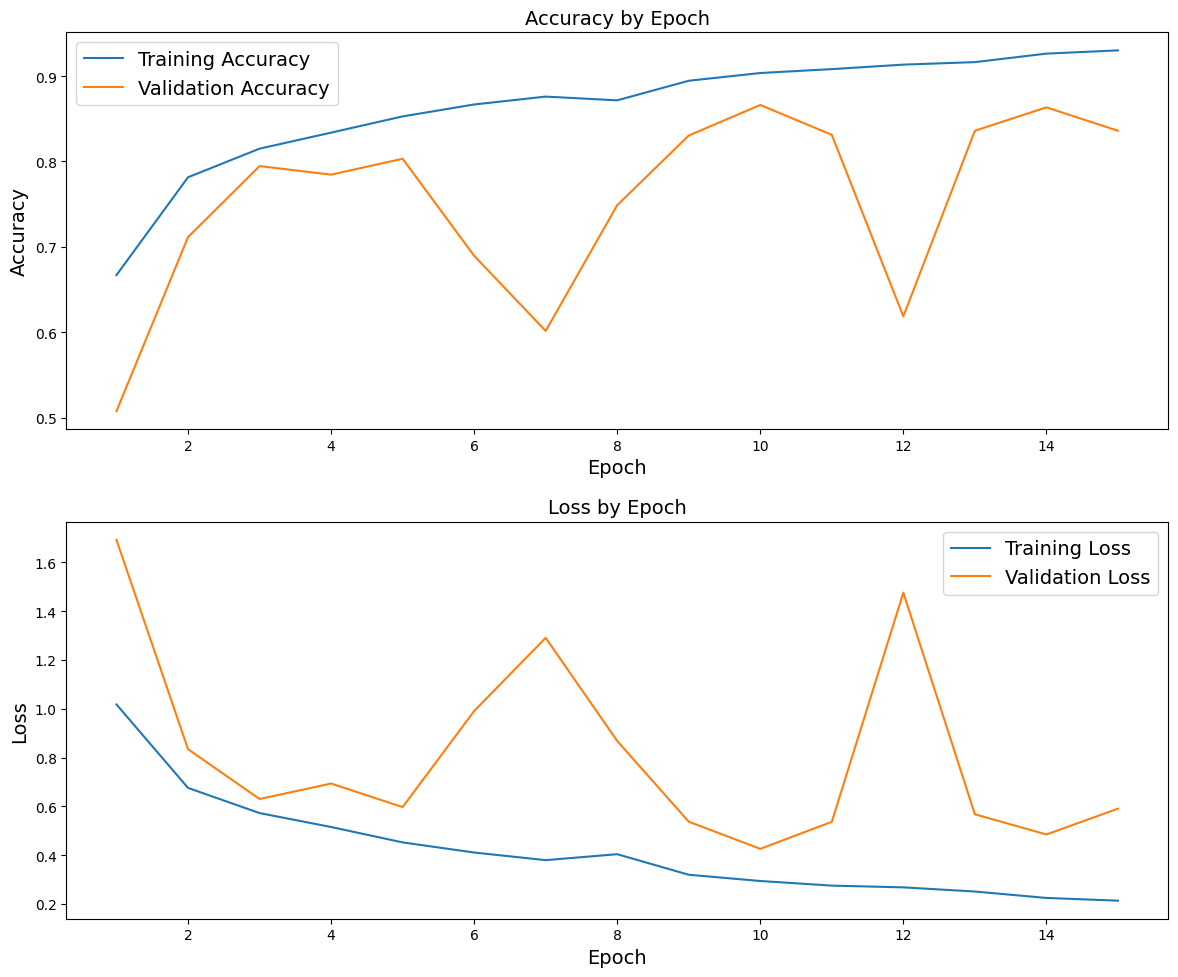

In [113]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_7_history_epochs, transfer_model_7_accuracy, label="Training Accuracy")
plt.plot(transfer_model_7_history_epochs, transfer_model_7_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_7_history_epochs, transfer_model_7_loss, label="Training Loss")
plt.plot(transfer_model_7_history_epochs, transfer_model_7_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [114]:
y_pred_transfer_model_7_probs = transfer_model_7.predict(X_test_scaled_96)
y_pred_transfer_model_7 = y_pred_transfer_model_7_probs.argmax(axis=1)
y_test_transfer_model_7 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_7, y_pred_transfer_model_7)
prec = precision_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted')
rec = recall_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted')
f1 = f1_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_7, y_pred_transfer_model_7, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step
model_2 Accuracy: 0.8628
model_2 Precision: 0.8632
model_2 Recall: 0.8628
model_2 F1 Score: 0.8616

              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.90      0.95      0.93      1000
        bird       0.80      0.85      0.82      1000
         cat       0.81      0.70      0.75      1000
        deer       0.87      0.85      0.86      1000
         dog       0.86      0.78      0.82      1000
        frog       0.83      0.94      0.88      1000
       horse       0.92      0.85      0.88      1000
        ship       0.93      0.92      0.92      1000
       truck       0.85      0.93      0.89      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



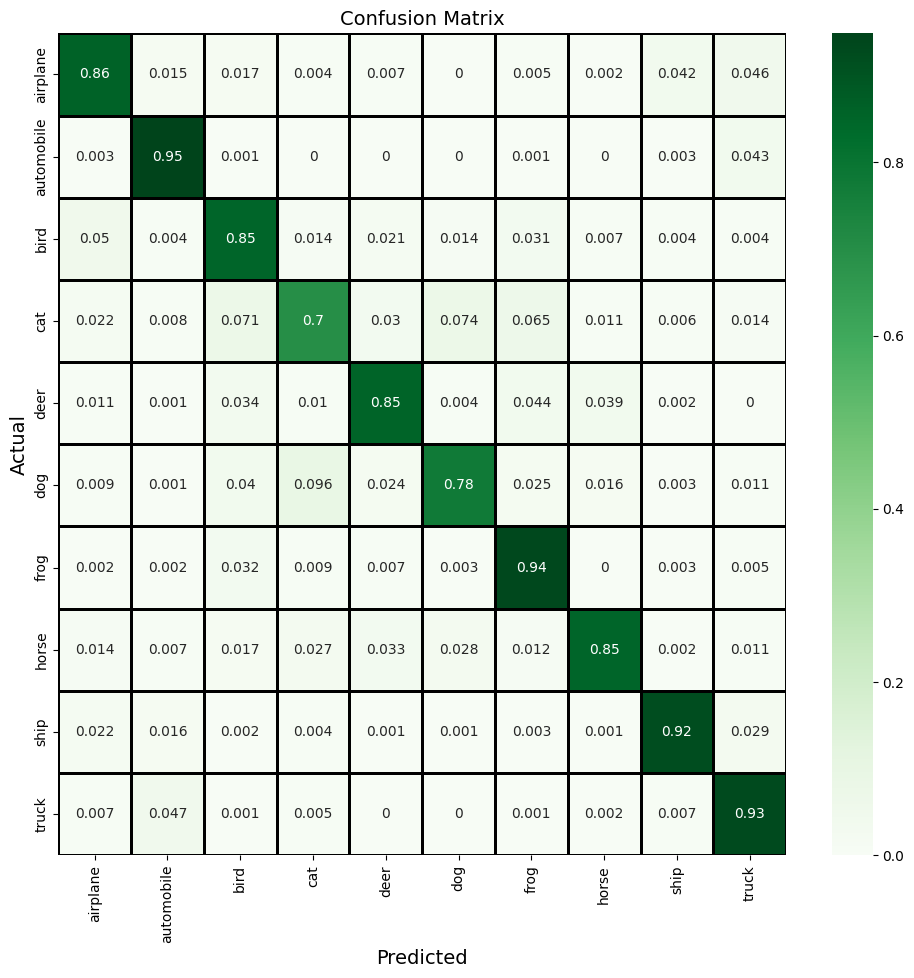

In [115]:
cm_transfer_model_7 = confusion_matrix(y_test_transfer_model_7, y_pred_transfer_model_7,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_7,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Back to 64,64,3 for freezing position experiments

# Transfer Learning Mobile Net v2  - Unfreezing Test 1 - (-80:-40) ,(64,64,3)

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [116]:
base_model_8 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

/tmp/ipykernel_164855/1078815345.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_8 = MobileNetV2(


In [117]:
len(base_model_8.layers)

154

In [118]:
for layer in base_model_8.layers[-80:-40]:
    layer.trainable = True


In [119]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [120]:
transfer_model_8 = models.Sequential([
    base_model_8,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [121]:
transfer_model_8_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_8.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_8_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [122]:
transfer_model_8_history = transfer_model_8.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.6779 - loss: 1.0020 - val_accuracy: 0.3300 - val_loss: 4.3670
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7713 - loss: 0.7244 - val_accuracy: 0.3580 - val_loss: 5.1180
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8105 - loss: 0.5997 - val_accuracy: 0.4702 - val_loss: 3.7833
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.8295 - loss: 0.5421 - val_accuracy: 0.7110 - val_loss: 1.1189
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8545 - loss: 0.4581 - val_accuracy: 0.6418 - val_loss: 2.0784
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.8622 - loss: 0.4346 - val_accuracy: 0.7366 - val_loss: 1.3024
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.8798 - loss: 0.3750 - val_accuracy: 0.7262 - val_loss: 1.1437
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.8681 - loss: 0

## Evaluating Model

In [123]:
transfer_model_8_accuracy = transfer_model_8_history.history["accuracy"]
transfer_model_8_accuracy_val = transfer_model_8_history.history["val_accuracy"]
transfer_model_8_loss = transfer_model_8_history.history["loss"]
transfer_model_8_loss_val = transfer_model_8_history.history["val_loss"]

transfer_model_8_history_epochs = range(1,len(transfer_model_8_accuracy)+1)

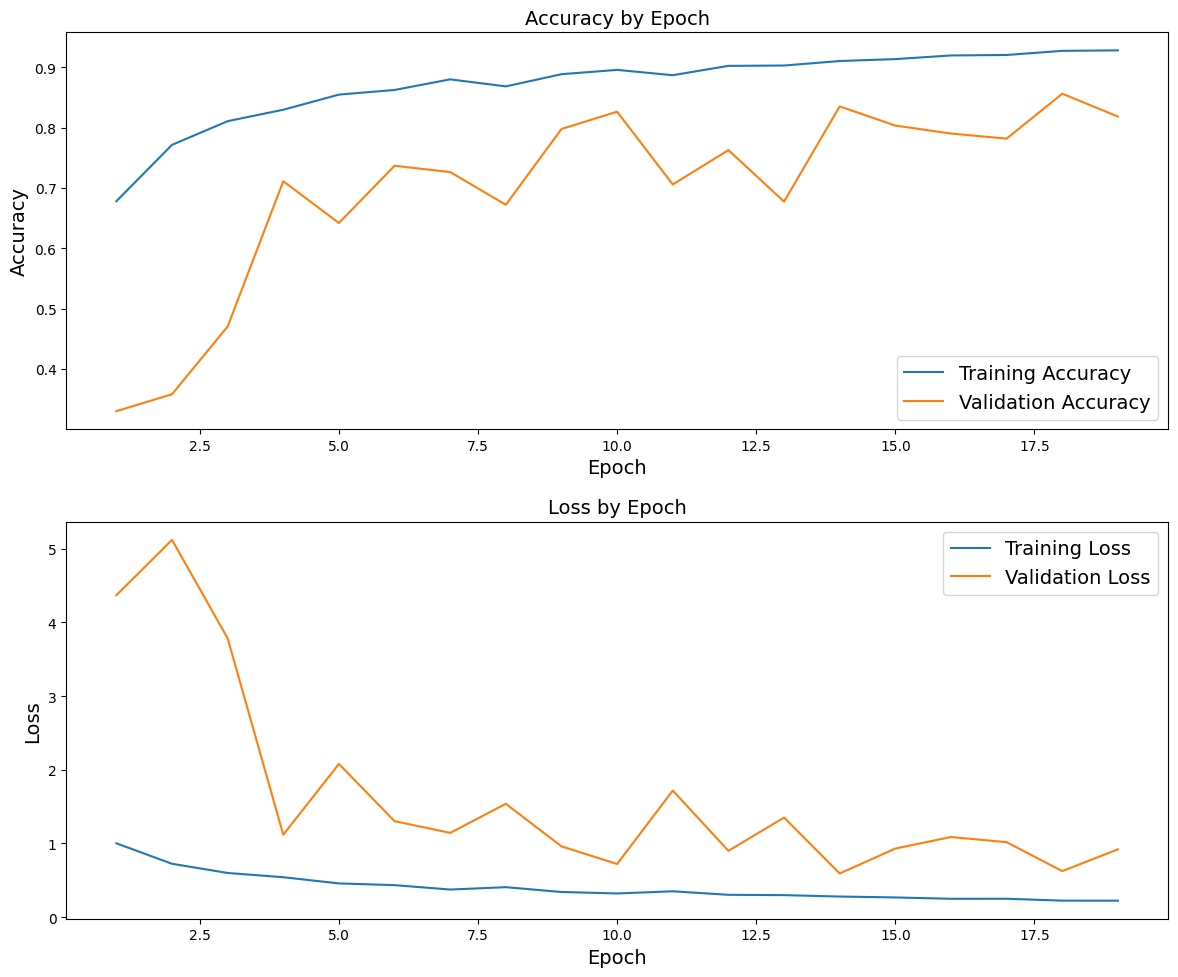

In [124]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_8_history_epochs, transfer_model_8_accuracy, label="Training Accuracy")
plt.plot(transfer_model_8_history_epochs, transfer_model_8_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_8_history_epochs, transfer_model_8_loss, label="Training Loss")
plt.plot(transfer_model_8_history_epochs, transfer_model_8_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [125]:
y_pred_transfer_model_8_probs = transfer_model_8.predict(X_test_scaled_64)
y_pred_transfer_model_8 = y_pred_transfer_model_8_probs.argmax(axis=1)
y_test_transfer_model_8 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_8, y_pred_transfer_model_8)
prec = precision_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted')
rec = recall_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted')
f1 = f1_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted')

print(f"model_8 Accuracy: {acc:.4f}")
print(f"model_8 Precision: {prec:.4f}")
print(f"model_8 Recall: {rec:.4f}")
print(f"model_8 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_8, y_pred_transfer_model_8, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
model_8 Accuracy: 0.8344
model_8 Precision: 0.8420
model_8 Recall: 0.8344
model_8 F1 Score: 0.8327

              precision    recall  f1-score   support

    airplane       0.93      0.76      0.84      1000
  automobile       0.79      0.98      0.87      1000
        bird       0.76      0.86      0.81      1000
         cat       0.78      0.57      0.66      1000
        deer       0.94      0.80      0.86      1000
         dog       0.70      0.88      0.78      1000
        frog       0.91      0.84      0.87      1000
       horse       0.87      0.88      0.88      1000
        ship       0.87      0.89      0.88      1000
       truck       0.88      0.88      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



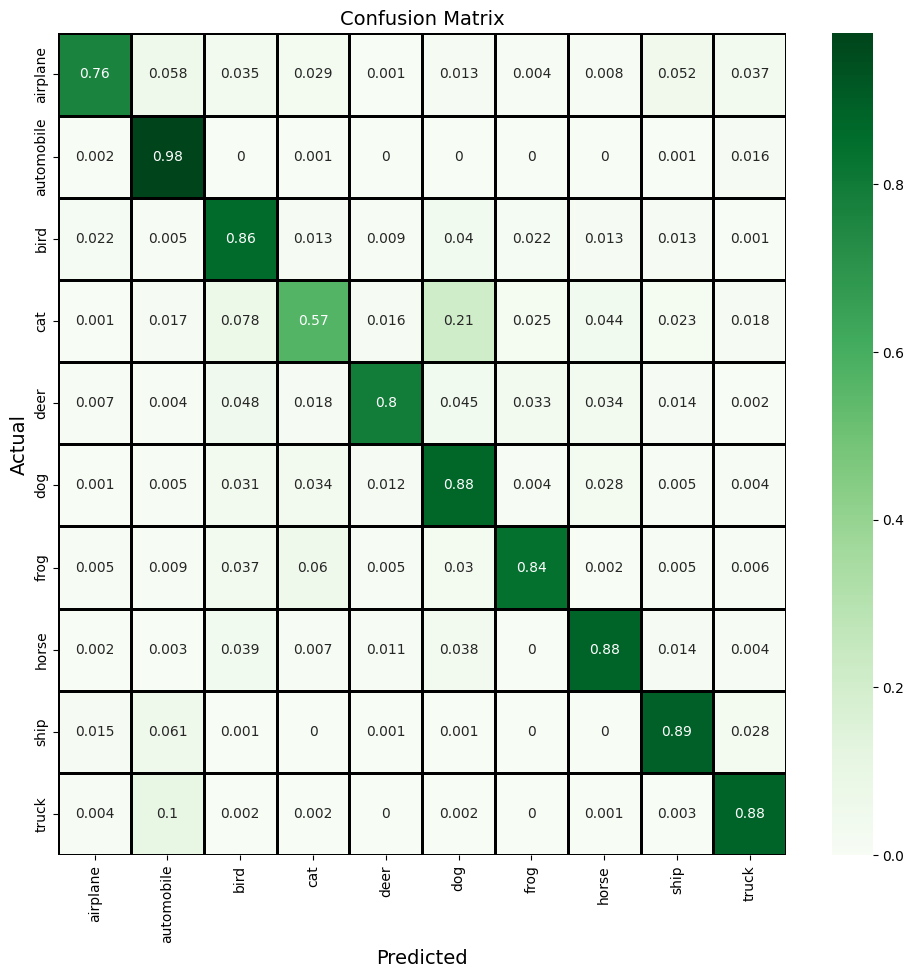

In [126]:
cm_transfer_model_8 = confusion_matrix(y_test_transfer_model_8, y_pred_transfer_model_8,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_8,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning Mobile Net v2 - Unfreezing Test 2 - Unfreezing Deeper - -120:-80

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [127]:
base_model_9 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

/tmp/ipykernel_164855/643763629.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_9 = MobileNetV2(


In [128]:
len(base_model_9.layers)

154

In [129]:
for layer in base_model_9.layers[-120:-80]:
    layer.trainable = True


In [130]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [131]:
transfer_model_9 = models.Sequential([
    base_model_9,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [132]:
transfer_model_9_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_9.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_9_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [133]:
transfer_model_9_history = transfer_model_9.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - accuracy: 0.6946 - loss: 0.9634 - val_accuracy: 0.3646 - val_loss: 5.2815
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.7725 - loss: 0.7137 - val_accuracy: 0.2866 - val_loss: 6.1572
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8078 - loss: 0.6054 - val_accuracy: 0.2706 - val_loss: 8.0597
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8190 - loss: 0.5616 - val_accuracy: 0.6892 - val_loss: 1.5180
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8322 - loss: 0.5269 - val_accuracy: 0.6526 - val_loss: 1.4068
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8122 - loss: 0.5692 - val_accuracy: 0.1172 - val_loss: 2.4136
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8115 - loss: 0.5752 - val_accuracy: 0.5340 - val_loss: 2.1571
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8105 - loss: 0

## Evaluating Model

In [134]:
transfer_model_9_accuracy = transfer_model_9_history.history["accuracy"]
transfer_model_9_accuracy_val = transfer_model_9_history.history["val_accuracy"]
transfer_model_9_loss = transfer_model_9_history.history["loss"]
transfer_model_9_loss_val = transfer_model_9_history.history["val_loss"]

transfer_model_9_history_epochs = range(1,len(transfer_model_9_accuracy)+1)

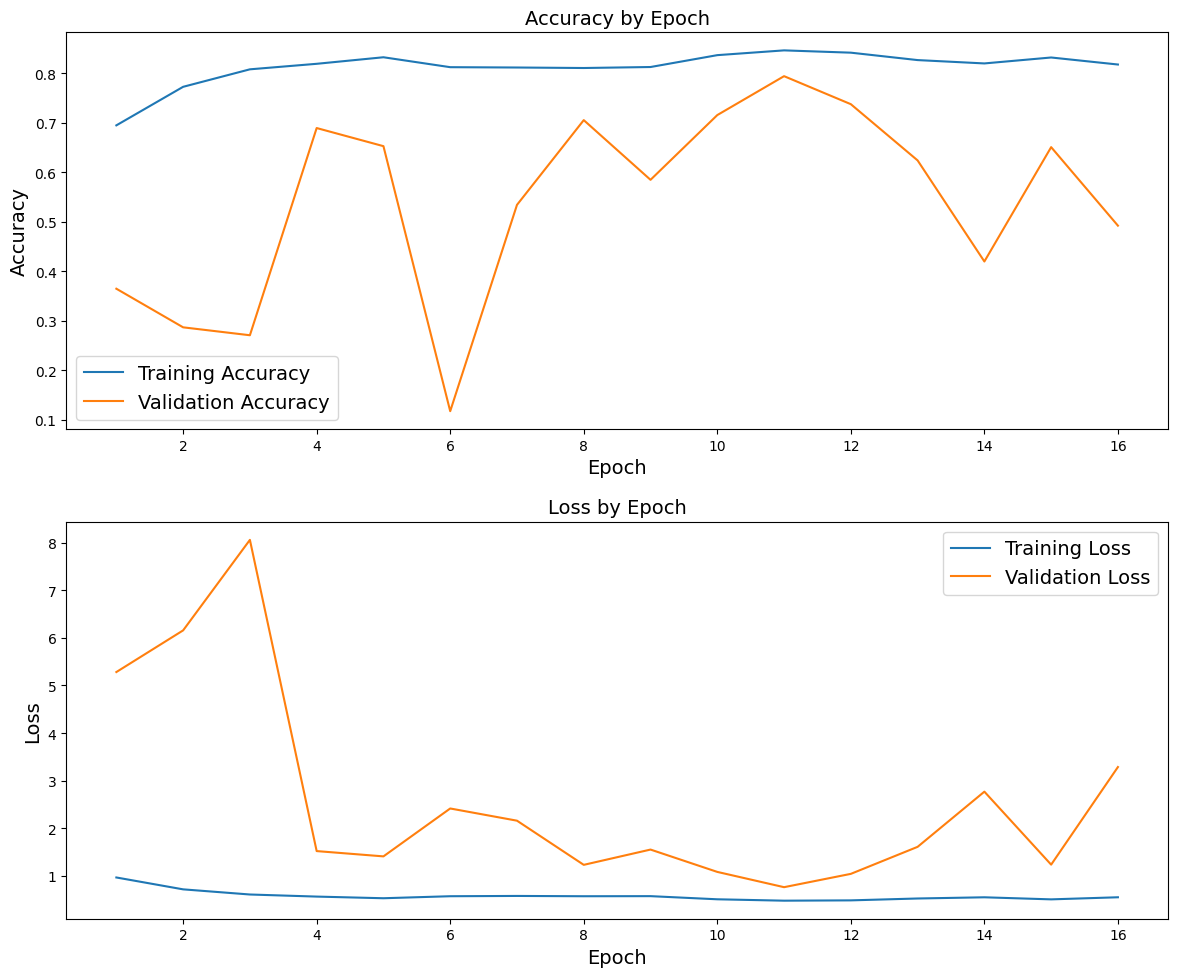

In [135]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_9_history_epochs, transfer_model_9_accuracy, label="Training Accuracy")
plt.plot(transfer_model_9_history_epochs, transfer_model_9_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_9_history_epochs, transfer_model_9_loss, label="Training Loss")
plt.plot(transfer_model_9_history_epochs, transfer_model_9_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [136]:
y_pred_transfer_model_9_probs = transfer_model_9.predict(X_test_scaled_64)
y_pred_transfer_model_9 = y_pred_transfer_model_9_probs.argmax(axis=1)
y_test_transfer_model_9 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_9, y_pred_transfer_model_9)
prec = precision_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted')
rec = recall_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted')
f1 = f1_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted')

print(f"model_9 Accuracy: {acc:.4f}")
print(f"model_9 Precision: {prec:.4f}")
print(f"model_9 Recall: {rec:.4f}")
print(f"model_9 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_9, y_pred_transfer_model_9, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
model_9 Accuracy: 0.8004
model_9 Precision: 0.8215
model_9 Recall: 0.8004
model_9 F1 Score: 0.8022

              precision    recall  f1-score   support

    airplane       0.95      0.66      0.78      1000
  automobile       0.86      0.97      0.91      1000
        bird       0.62      0.89      0.73      1000
         cat       0.64      0.68      0.66      1000
        deer       0.85      0.80      0.83      1000
         dog       0.62      0.70      0.66      1000
        frog       0.94      0.82      0.87      1000
       horse       0.95      0.67      0.79      1000
        ship       0.87      0.93      0.90      1000
       truck       0.89      0.89      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000



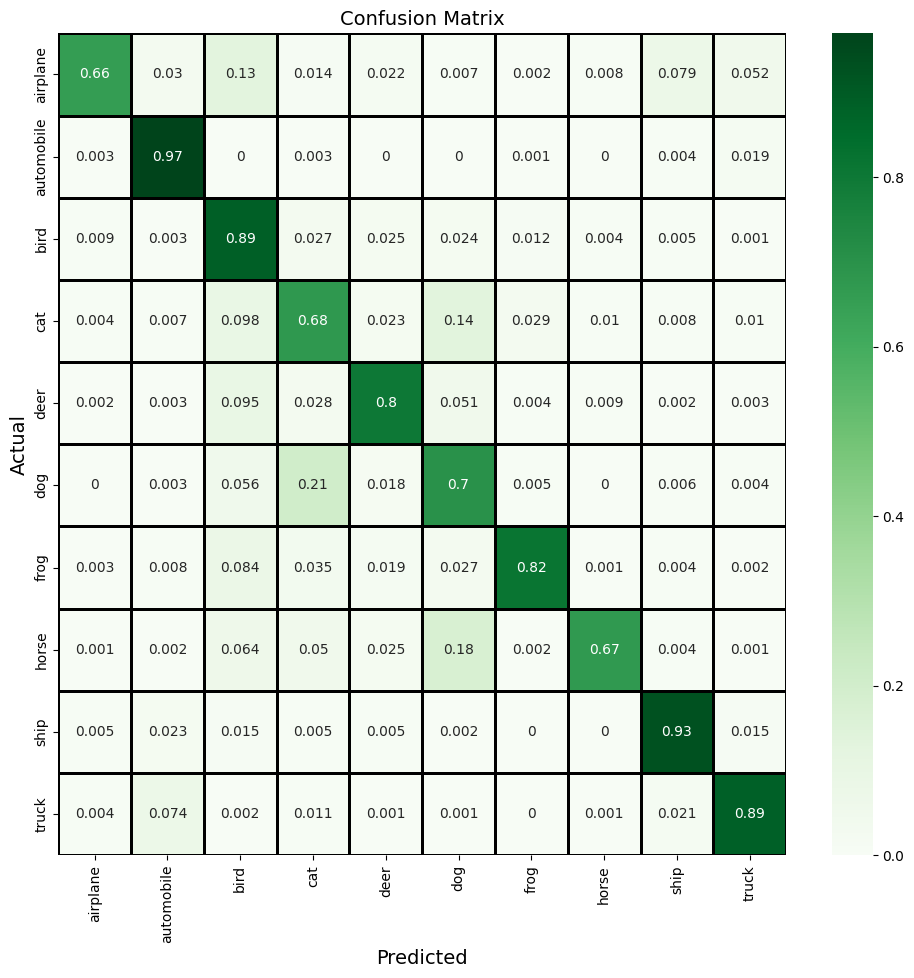

In [137]:
cm_transfer_model_9 = confusion_matrix(y_test_transfer_model_9, y_pred_transfer_model_9,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_9,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Transfer Learning Mobile Net v2 - Unfreezing Test 3 - Unfreezing from the Bottom - 0:40

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [138]:
base_model_10 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

/tmp/ipykernel_164855/3525371919.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_10 = MobileNetV2(


In [139]:
len(base_model_10.layers)

154

In [140]:
for layer in base_model_10.layers[0:40]:
    layer.trainable = True


In [141]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [142]:
transfer_model_10 = models.Sequential([
    base_model_10,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [143]:
transfer_model_10_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_10.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_10_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [144]:
transfer_model_10_history = transfer_model_10.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 76ms/step - accuracy: 0.6959 - loss: 0.9586 - val_accuracy: 0.4762 - val_loss: 2.5367
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8111 - loss: 0.5975 - val_accuracy: 0.5226 - val_loss: 2.5674
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7970 - loss: 0.6432 - val_accuracy: 0.5502 - val_loss: 2.6359
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8292 - loss: 0.5360 - val_accuracy: 0.5230 - val_loss: 3.6882
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8486 - loss: 0.4772 - val_accuracy: 0.5416 - val_loss: 2.7070
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8507 - loss: 0.4668 - val_accuracy: 0.6946 - val_loss: 1.1872
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.8612 - loss: 0.4309 - val_accuracy: 0.6792 - val_loss: 1.4946
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.8824 - loss: 0

## Evaluating Model

In [145]:
transfer_model_10_accuracy = transfer_model_10_history.history["accuracy"]
transfer_model_10_accuracy_val = transfer_model_10_history.history["val_accuracy"]
transfer_model_10_loss = transfer_model_10_history.history["loss"]
transfer_model_10_loss_val = transfer_model_10_history.history["val_loss"]

transfer_model_10_history_epochs = range(1,len(transfer_model_10_accuracy)+1)

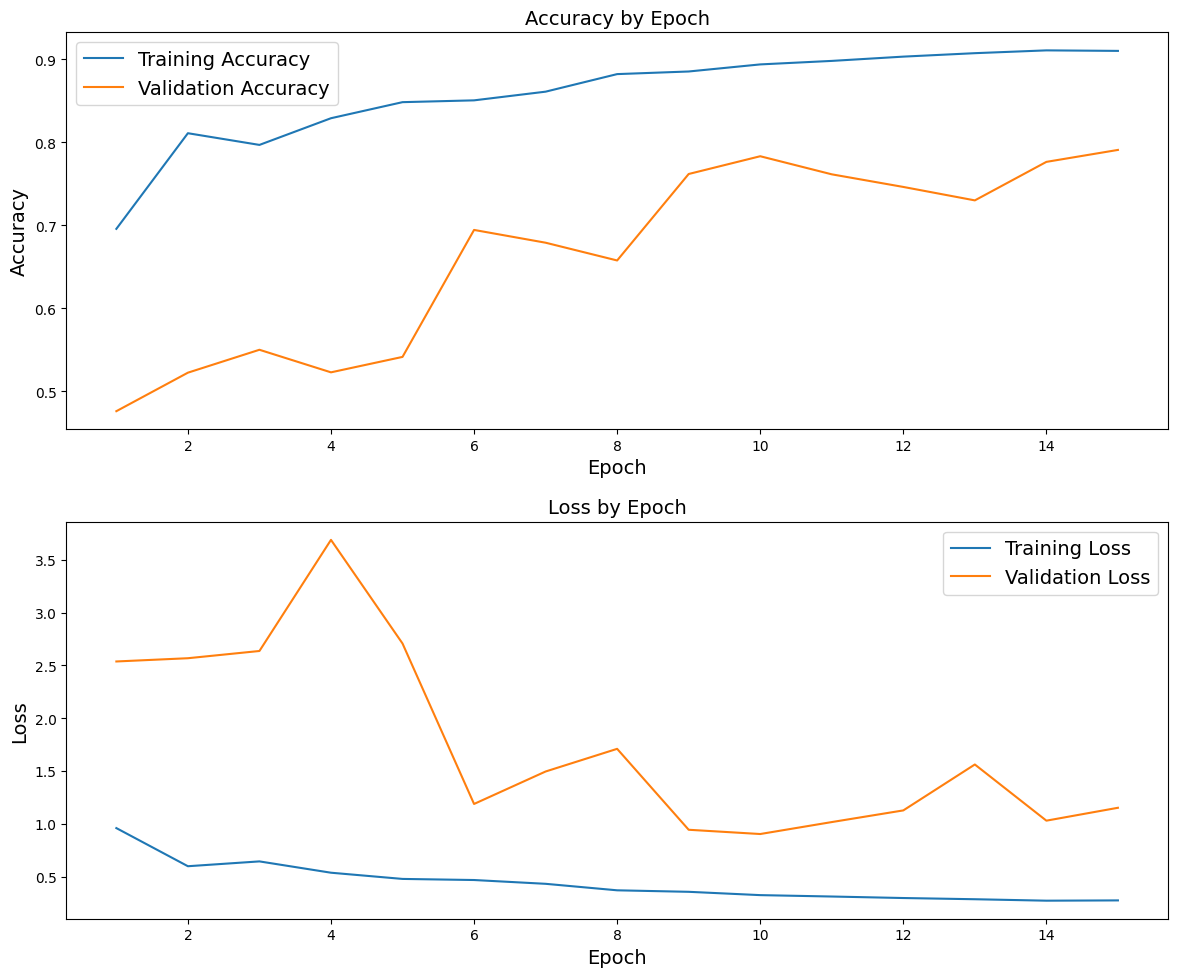

In [146]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_10_history_epochs, transfer_model_10_accuracy, label="Training Accuracy")
plt.plot(transfer_model_10_history_epochs, transfer_model_10_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_10_history_epochs, transfer_model_10_loss, label="Training Loss")
plt.plot(transfer_model_10_history_epochs, transfer_model_10_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [147]:
y_pred_transfer_model_10_probs = transfer_model_10.predict(X_test_scaled_64)
y_pred_transfer_model_10 = y_pred_transfer_model_10_probs.argmax(axis=1)
y_test_transfer_model_10 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_10, y_pred_transfer_model_10)
prec = precision_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted')
rec = recall_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted')
f1 = f1_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted')

print(f"model_10 Accuracy: {acc:.4f}")
print(f"model_10 Precision: {prec:.4f}")
print(f"model_10 Recall: {rec:.4f}")
print(f"model_10 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_10, y_pred_transfer_model_10, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
model_10 Accuracy: 0.7881
model_10 Precision: 0.8332
model_10 Recall: 0.7881
model_10 F1 Score: 0.7940

              precision    recall  f1-score   support

    airplane       0.83      0.84      0.84      1000
  automobile       0.88      0.95      0.91      1000
        bird       0.48      0.96      0.64      1000
         cat       0.76      0.62      0.68      1000
        deer       0.94      0.63      0.75      1000
         dog       0.80      0.75      0.78      1000
        frog       0.92      0.75      0.83      1000
       horse       0.90      0.80      0.85      1000
        ship       0.98      0.65      0.78      1000
       truck       0.85      0.92      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.83      0.79      0.79     10000
weighted avg       0.83      0.79      0.79     10000



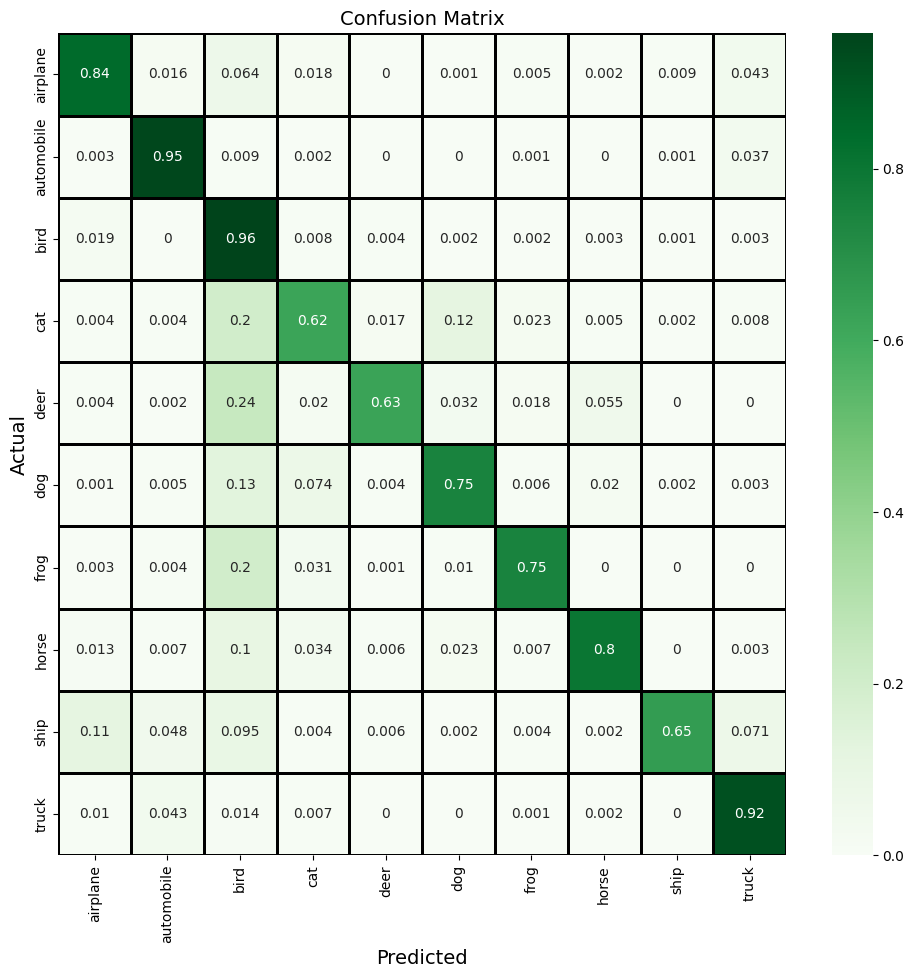

In [148]:
cm_transfer_model_10 = confusion_matrix(y_test_transfer_model_10, y_pred_transfer_model_10,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_transfer_model_10,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# model_2 at 96,96,3

## Architecture

In [149]:
model_2_scaled_96 = tf.keras.Sequential([
    tf.keras.Input(shape=(96,96,3)),
        tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                           # pooling layer

    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Conv2D(
        128,
        kernel_size=3,
        padding="valid",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Flatten(),                              # bridge to the dense layer

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [150]:
model_2_scaled_96.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,123,306 (8.10 MB)

 Trainable params: 2,123,306 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [151]:
model_2_scaled_96_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [152]:
model_2_scaled_96.compile(
    loss="categorical_crossentropy",
    optimizer= model_2_scaled_96_optimizer,
    metrics=["accuracy"]
    )

In [153]:
early_stopping = EarlyStopping(
    monitor='val_loss',                 # metric to monitor             
    patience=5,                         # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [154]:
model_2_scaled_96_history = model_2_scaled_96.fit(
    image_augmentor_scaled_96,
    epochs=100,
    validation_data=(X_valid_scaled_96, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.3360 - loss: 1.8126 - val_accuracy: 0.5168 - val_loss: 1.3663
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.4978 - loss: 1.3897 - val_accuracy: 0.6028 - val_loss: 1.1200
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.5773 - loss: 1.1922 - val_accuracy: 0.6570 - val_loss: 0.9962
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.6118 - loss: 1.0920 - val_accuracy: 0.7058 - val_loss: 0.8640
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.6372 - loss: 1.0261 - val_accuracy: 0.7142 - val_loss: 0.8167
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 67ms/step - accuracy: 0.6559 - loss: 0.9817 - val_accuracy: 0.7188 - val_loss: 0.8273
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.6707 - loss: 0.9410 - val_accuracy: 0.7518 - val_loss: 0.7471
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.6826 - loss: 0

## Evaluating Model

In [155]:
model_2_scaled_96_accuracy = model_2_scaled_96_history.history["accuracy"]
model_2_scaled_96_accuracy_val = model_2_scaled_96_history.history["val_accuracy"]
model_2_scaled_96_loss = model_2_scaled_96_history.history["loss"]
model_2_scaled_96_loss_val = model_2_scaled_96_history.history["val_loss"]

model_2_scaled_96_epochs = range(1,len(model_2_scaled_96_accuracy)+1)

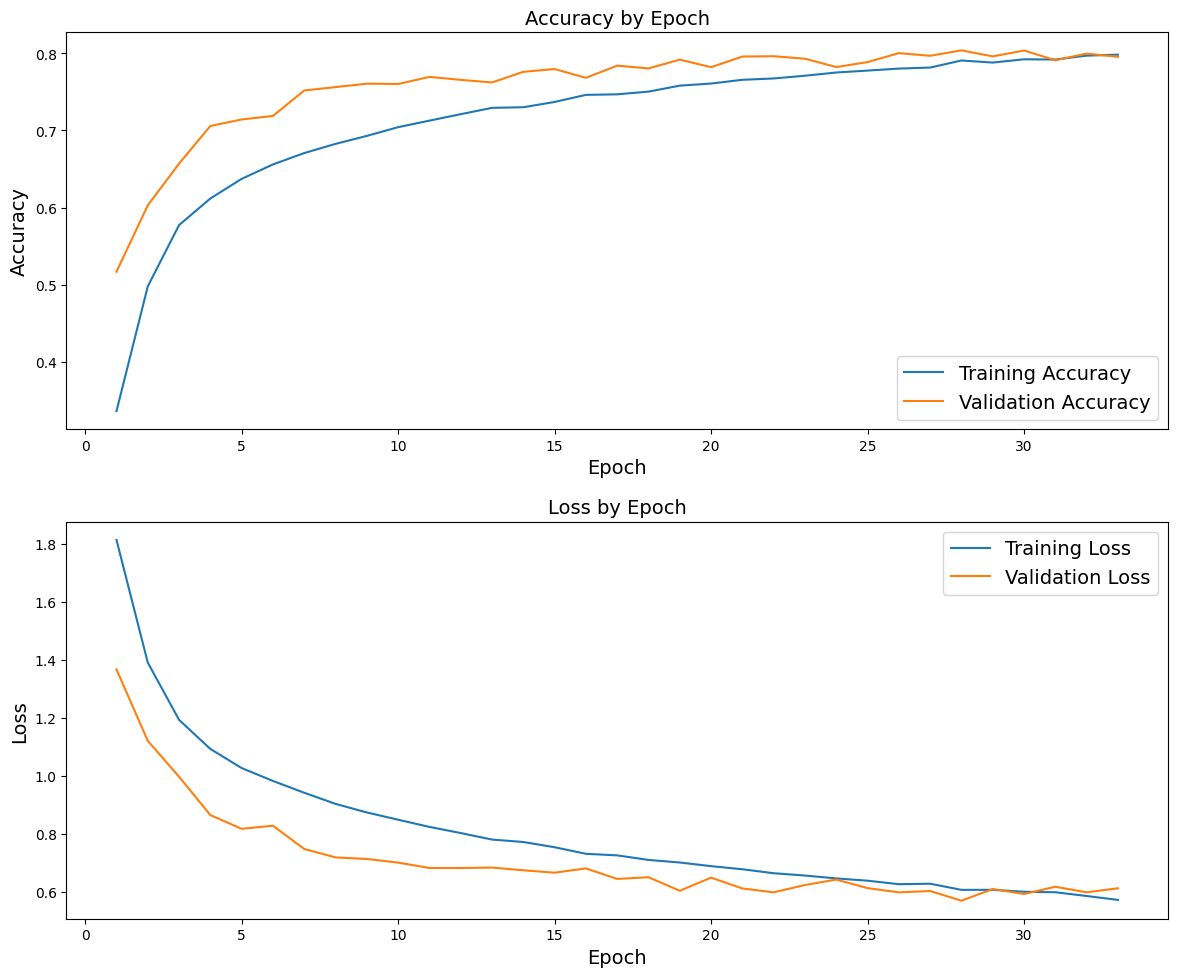

In [156]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_2_scaled_96_epochs, model_2_scaled_96_accuracy, label="Training Accuracy")
plt.plot(model_2_scaled_96_epochs, model_2_scaled_96_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_2_scaled_96_epochs, model_2_scaled_96_loss, label="Training Loss")
plt.plot(model_2_scaled_96_epochs, model_2_scaled_96_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [157]:
y_pred_model_2_scaled_96_probs = model_2_scaled_96.predict(X_test_scaled_96)
y_pred_model_2_scaled_96 = y_pred_model_2_scaled_96_probs.argmax(axis=1)
y_test_model_2_scaled_96 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96)
prec = precision_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')
rec = recall_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')
f1 = f1_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step
model_2 Accuracy: 0.8036
model_2 Precision: 0.8027
model_2 Recall: 0.8036
model_2 F1 Score: 0.8021

              precision    recall  f1-score   support

    airplane       0.83      0.84      0.83      1000
  automobile       0.93      0.88      0.91      1000
        bird       0.74      0.66      0.70      1000
         cat       0.70      0.60      0.65      1000
        deer       0.72      0.80      0.76      1000
         dog       0.74      0.73      0.74      1000
        frog       0.80      0.87      0.83      1000
       horse       0.83      0.84      0.84      1000
        ship       0.88      0.90      0.89      1000
       truck       0.87      0.90      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



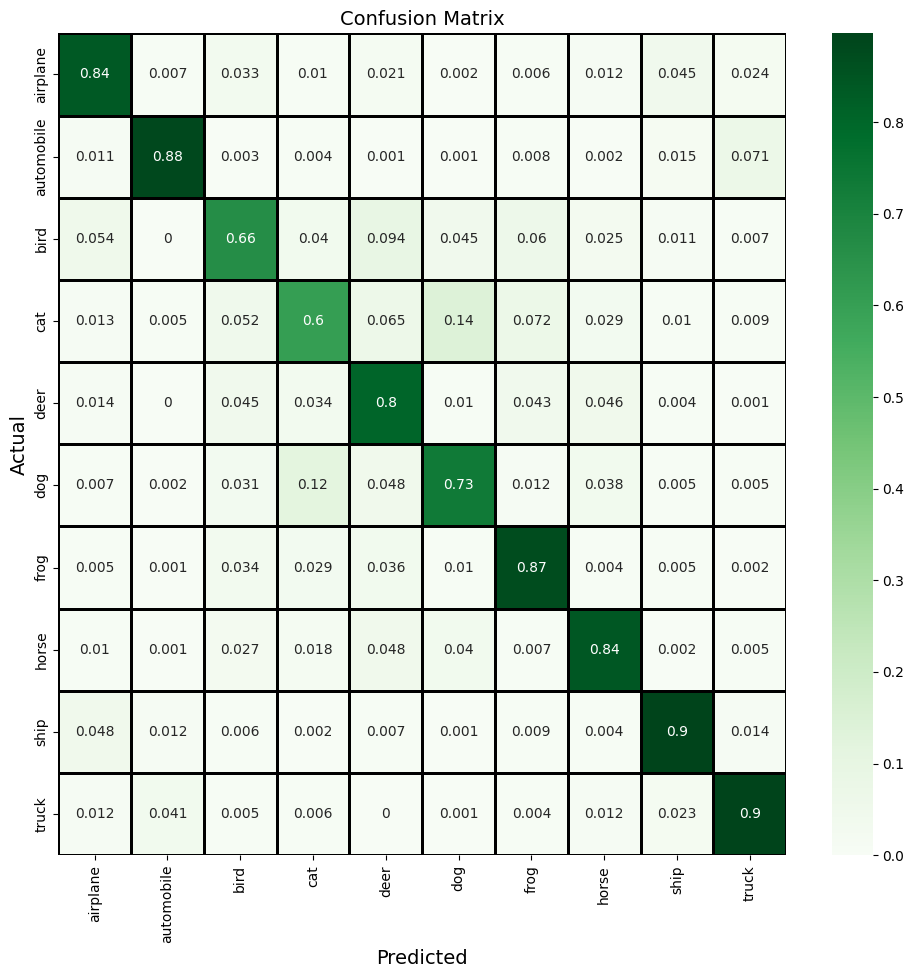

In [158]:
cm_model_2_scaled_96 = confusion_matrix(y_test_model_2_scaled_96, y_pred_model_2_scaled_96,normalize="true")

plt.figure(figsize=(10, 10))

sns.heatmap(
    cm_model_2_scaled_96,
    annot=True,
    annot_kws={"size": 10},
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,         
    linecolor="black")    


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Save The Models

In [ ]:
model_1.save("model_1")
model_2.save("model_2")
transfer_model_1.save("transfer_model_1")
transfer_model_2.save("transfer_model_2")
transfer_model_3.save("transfer_model_3")
transfer_model_4.save("transfer_model_4")
transfer_model_5.save("transfer_model_5")
transfer_model_6.save("transfer_model_6")
transfer_model_7.save("transfer_model_7")
transfer_model_8.save("transfer_model_8")
transfer_model_9.save("transfer_model_9")
transfer_model_10.save("transfer_model_10")
model_2_scaled_96.save("model_2_scaled_96")

# Overview of Classification Reports

In [ ]:

model_data_frame_data = {
    "Model Name": [
        "Local Convolutional Nueral Network 1",
        "Local Convolutional Nueral Network 2",
        "transfer_model_1 MNv2 Frozen scaled to 64,64,3",
        "transfer_model_2 MNv2 top 40 Unfrozen scaled to 64,64,3",
        "transfer_model_3 MNv2 top 20 Unfrozen scaled to 64,64,3",
        "transfer_model_4 ResN50v2 Frozen scaled to 64,64,3",
        "transfer_model_5 ResN50v2 top 49 Unfrozen scaled to 64,64,3",
        "transfer_model_6 MNv2 top 40 Unfrozen scaled to 96,96,3",
        "transfer_model_7 ResN50v2 top 49 Unfrozen scaled to 96,96,3",
        "transfer_model_8 MNv2 (-80:-40) Unfrozen scaled to 64,64,3"",
        "transfer_model_9 MNv2 (-120:-80) Unfrozen scaled to 64,64,3",
        "transfer_model_10 MNv2 (0:40) Unfrozen scaled to 64,64,3",
        "Local Convolutional Nueral Network 2 scaled to 96,96,3"
        ],
    "Accuracy": [
        accuracy_score(y_test_model_1, y_pred_model_1),
        accuracy_score(y_test_model_2, y_pred_model_2),
        accuracy_score(y_test_transfer_model_1, y_pred_transfer_model_1),
        accuracy_score(y_test_transfer_model_2, y_pred_transfer_model_2),
        accuracy_score(y_test_transfer_model_3, y_pred_transfer_model_3),
        accuracy_score(y_test_transfer_model_4, y_pred_transfer_model_4),
        accuracy_score(y_test_transfer_model_5, y_pred_transfer_model_5),
        accuracy_score(y_test_transfer_model_6, y_pred_transfer_model_6),
        accuracy_score(y_test_transfer_model_7, y_pred_transfer_model_7),
        accuracy_score(y_test_transfer_model_8, y_pred_transfer_model_8),
        accuracy_score(y_test_transfer_model_9, y_pred_transfer_model_9),
        accuracy_score(y_test_transfer_model_10, y_pred_transfer_model_10),
        accuracy_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96)      
        ],
    "Precision": [
        precision_score(y_test_model_1, y_pred_model_1, average='weighted'),
        precision_score(y_test_model_2, y_pred_model_2, average='weighted'),
        precision_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted'),
        precision_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted'),
        precision_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted'),
        precision_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted'),
        precision_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted'),
        precision_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted'),
        precision_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted'),
        precision_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted'),
        precision_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted'),
        precision_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted'),
        precision_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')
        ],
    "Recall": [
        recall_score(y_test_model_1, y_pred_model_1, average='weighted'),
        recall_score(y_test_model_2, y_pred_model_2, average='weighted'),
        recall_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted'),
        recall_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted'),
        recall_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted'),
        recall_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted'),
        recall_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted'),
        recall_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted'),
        recall_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted'),
        recall_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted'),
        recall_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted'),
        recall_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted'),
        recall_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')      
        ],
    "F1_Score": [
        f1_score(y_test_model_1, y_pred_model_1, average='weighted'),
        f1_score(y_test_model_2, y_pred_model_2, average='weighted'),
        f1_score(y_test_transfer_model_1, y_pred_transfer_model_1, average='weighted'),
        f1_score(y_test_transfer_model_2, y_pred_transfer_model_2, average='weighted'),
        f1_score(y_test_transfer_model_3, y_pred_transfer_model_3, average='weighted'),
        f1_score(y_test_transfer_model_4, y_pred_transfer_model_4, average='weighted'),
        f1_score(y_test_transfer_model_5, y_pred_transfer_model_5, average='weighted'),
        f1_score(y_test_transfer_model_6, y_pred_transfer_model_6, average='weighted'),
        f1_score(y_test_transfer_model_7, y_pred_transfer_model_7, average='weighted'),
        f1_score(y_test_transfer_model_8, y_pred_transfer_model_8, average='weighted'),
        f1_score(y_test_transfer_model_9, y_pred_transfer_model_9, average='weighted'),
        f1_score(y_test_transfer_model_10, y_pred_transfer_model_10, average='weighted'),
        f1_score(y_test_model_2_scaled_96, y_pred_model_2_scaled_96, average='weighted')     
        ]
}


In [ ]:
model_data_frame = pd.dataframe(model_data_frame_data)

display(model_data_frame)



In [ ]:
model_data_frame.to_csv("model_data_frame.csv", index = False)